# **Load Library & Data**

In [14]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
from matplotlib import style
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

%matplotlib inline

In [15]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./Test.csv')
submission = pd.read_csv('./submission_sample.csv')

# 간단 EDA

**범주형 변수**의 분포를 살펴보자.

In [16]:
categorical = train.select_dtypes(object).columns

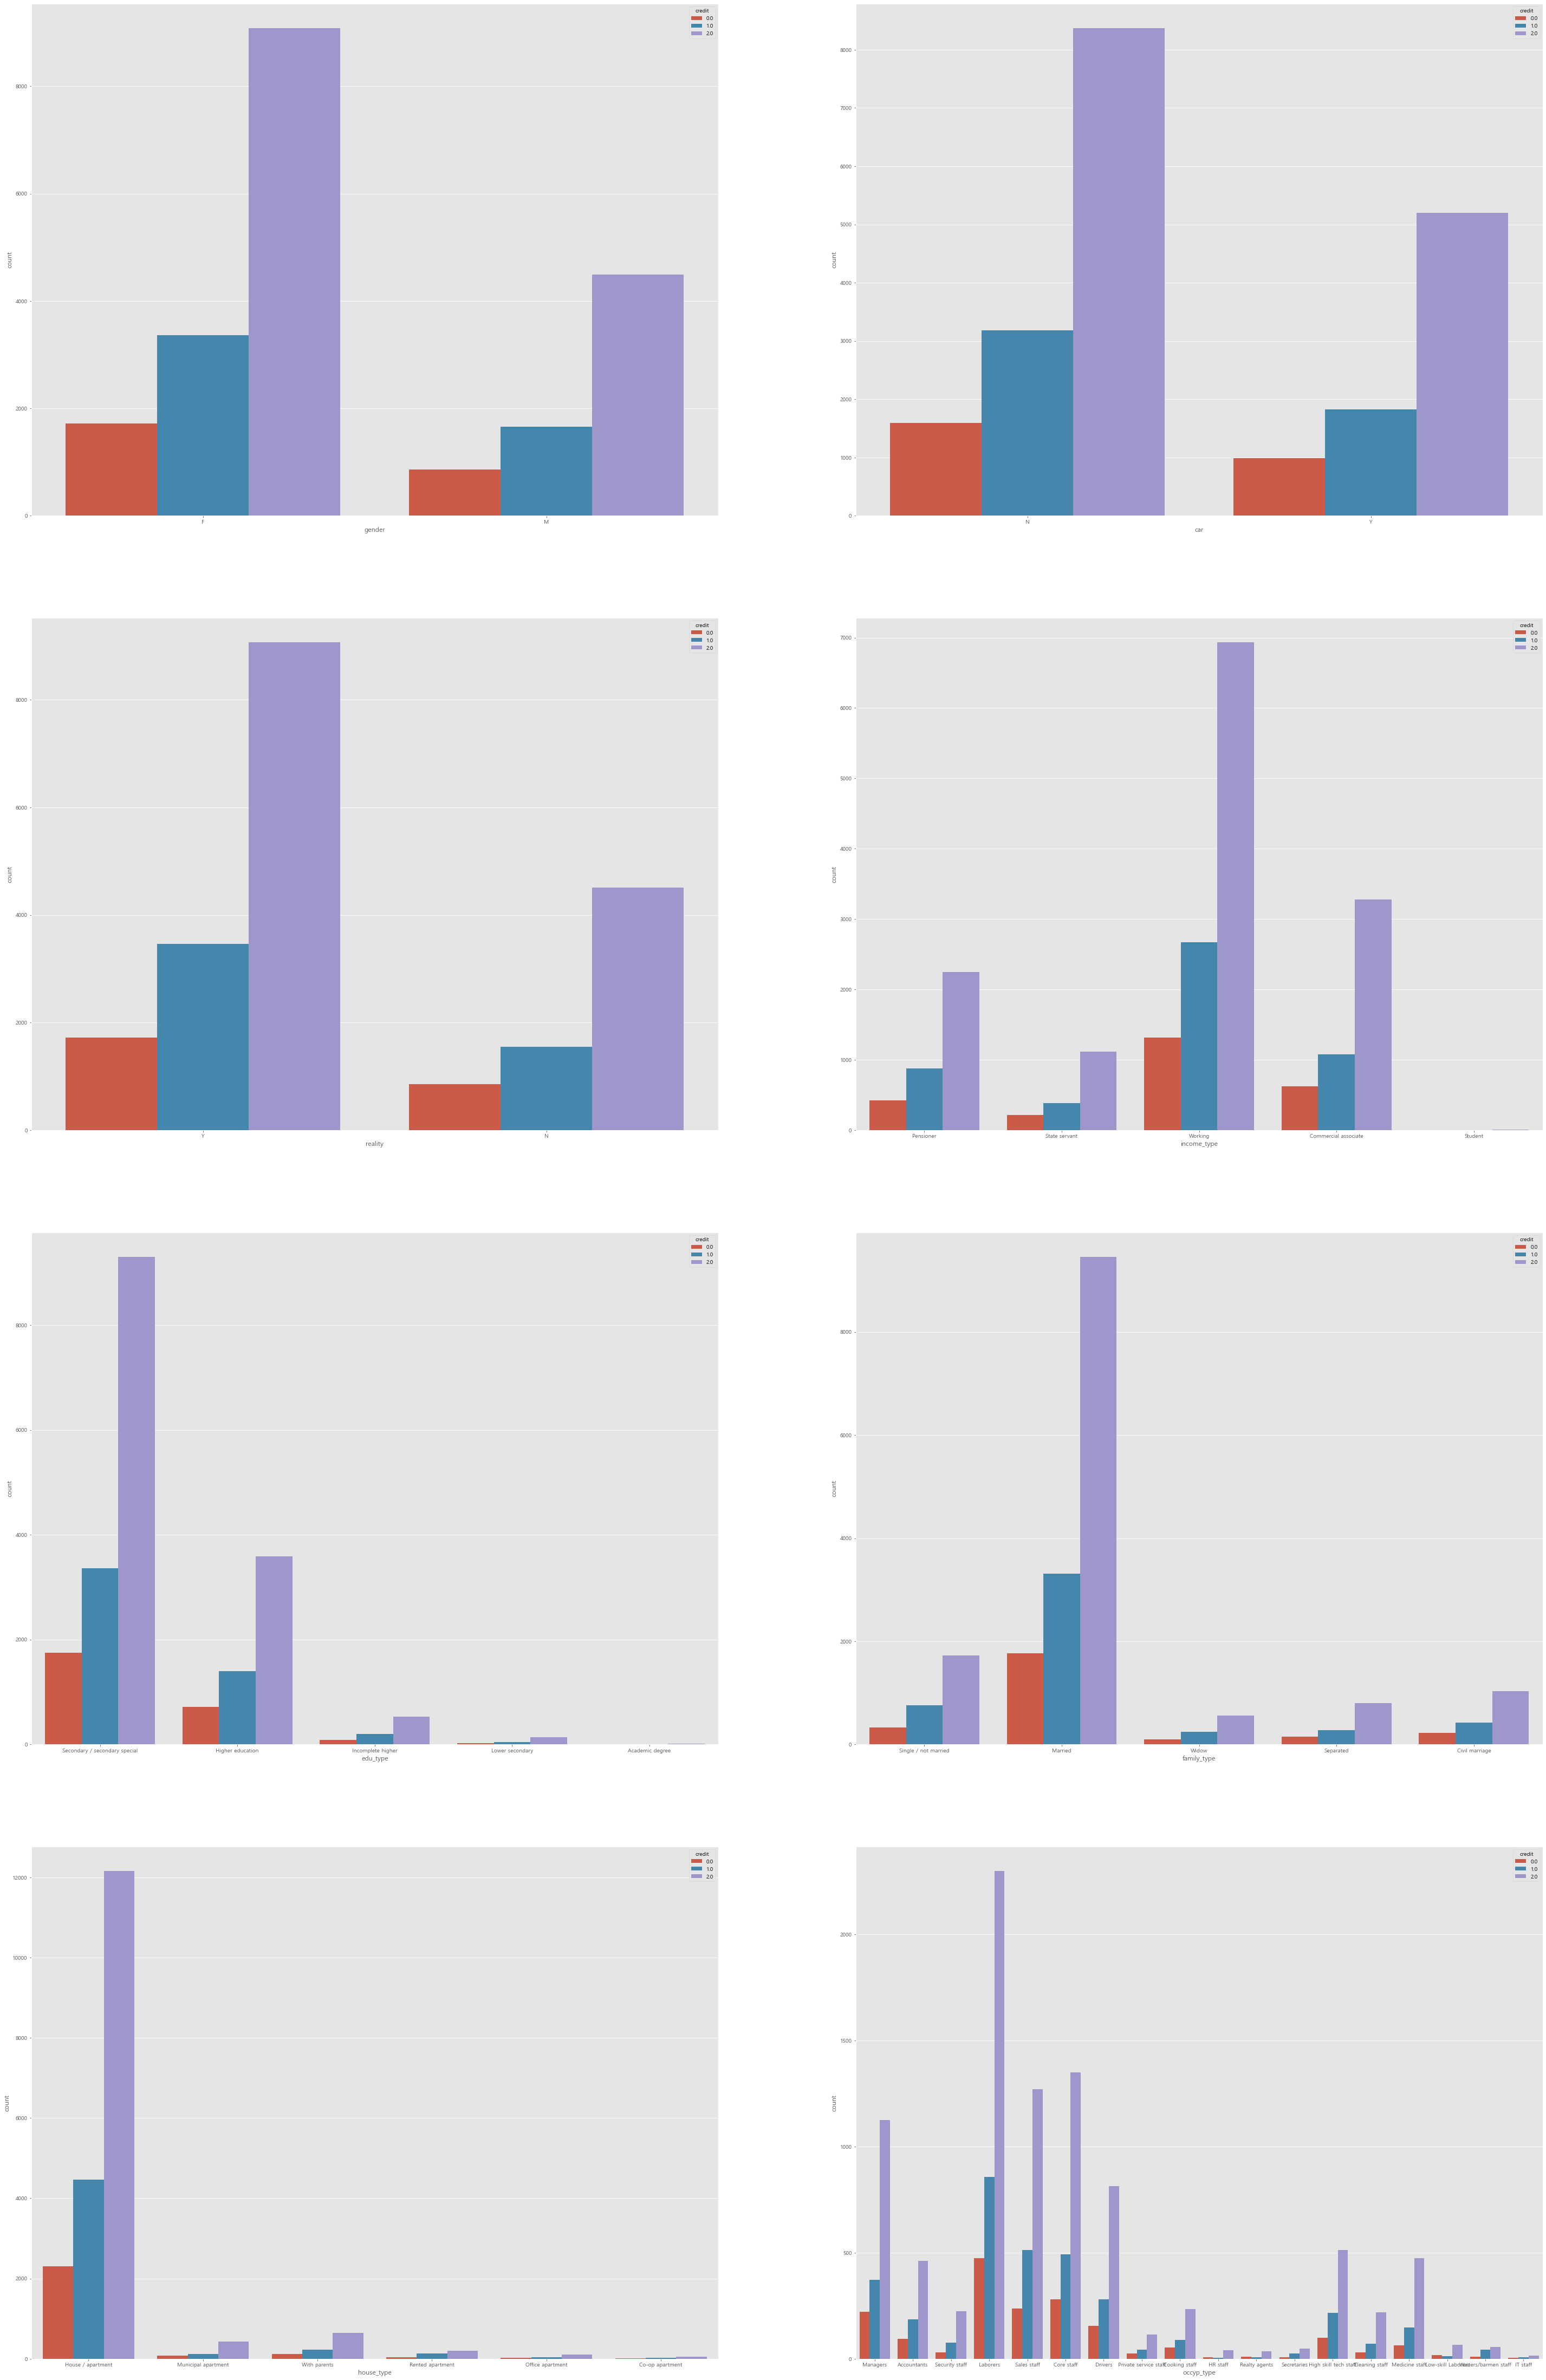

In [4]:
fig, axs = plt.subplots(figsize=(50,80), ncols=2, nrows=4)

for i, feature in enumerate(categorical):
  row=int(i/2)
  col=i%2
  sns.countplot(x=feature,data=train,hue='credit',ax=axs[row][col])

- 모든 feature의 category 별로 credit 분포의 큰 차이를 발견할 수 없었다.

**연속형 변수**의 credit별 분포를 살펴보자

In [17]:
num = ['child_num','income_total','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','phone','email','begin_month']

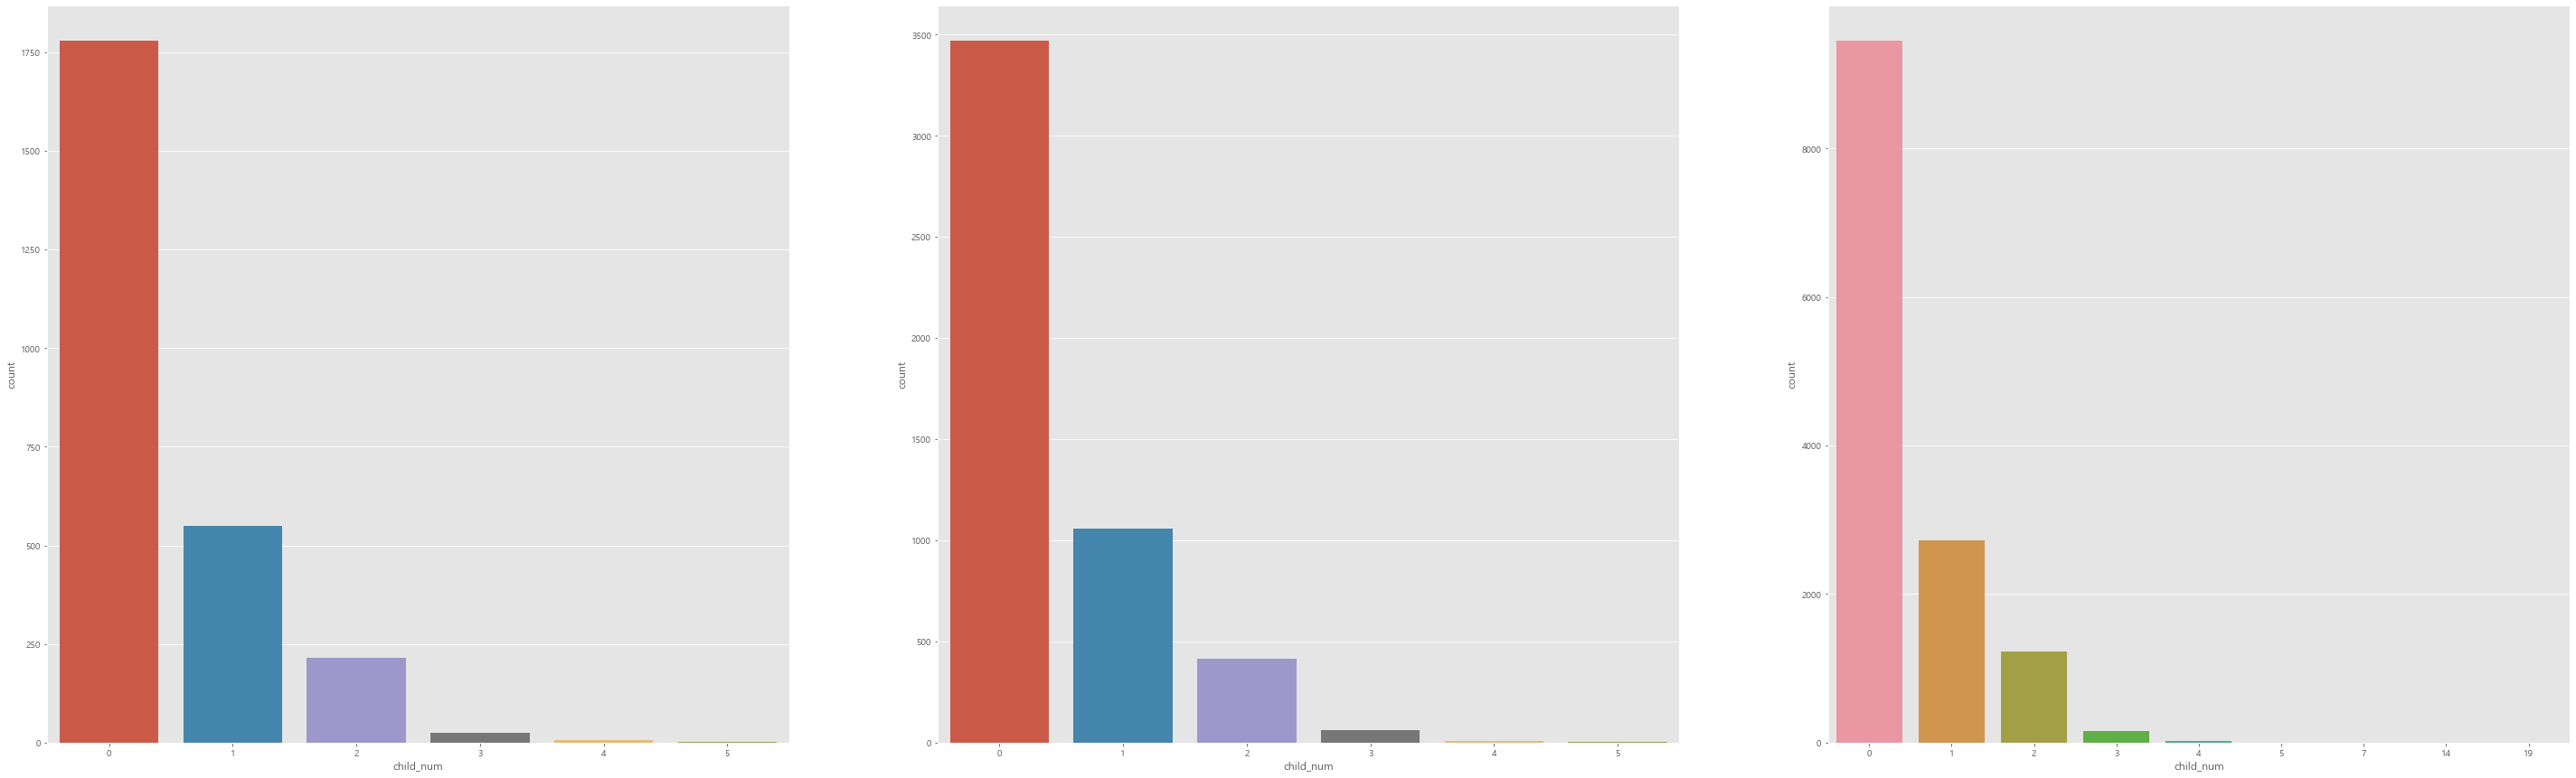

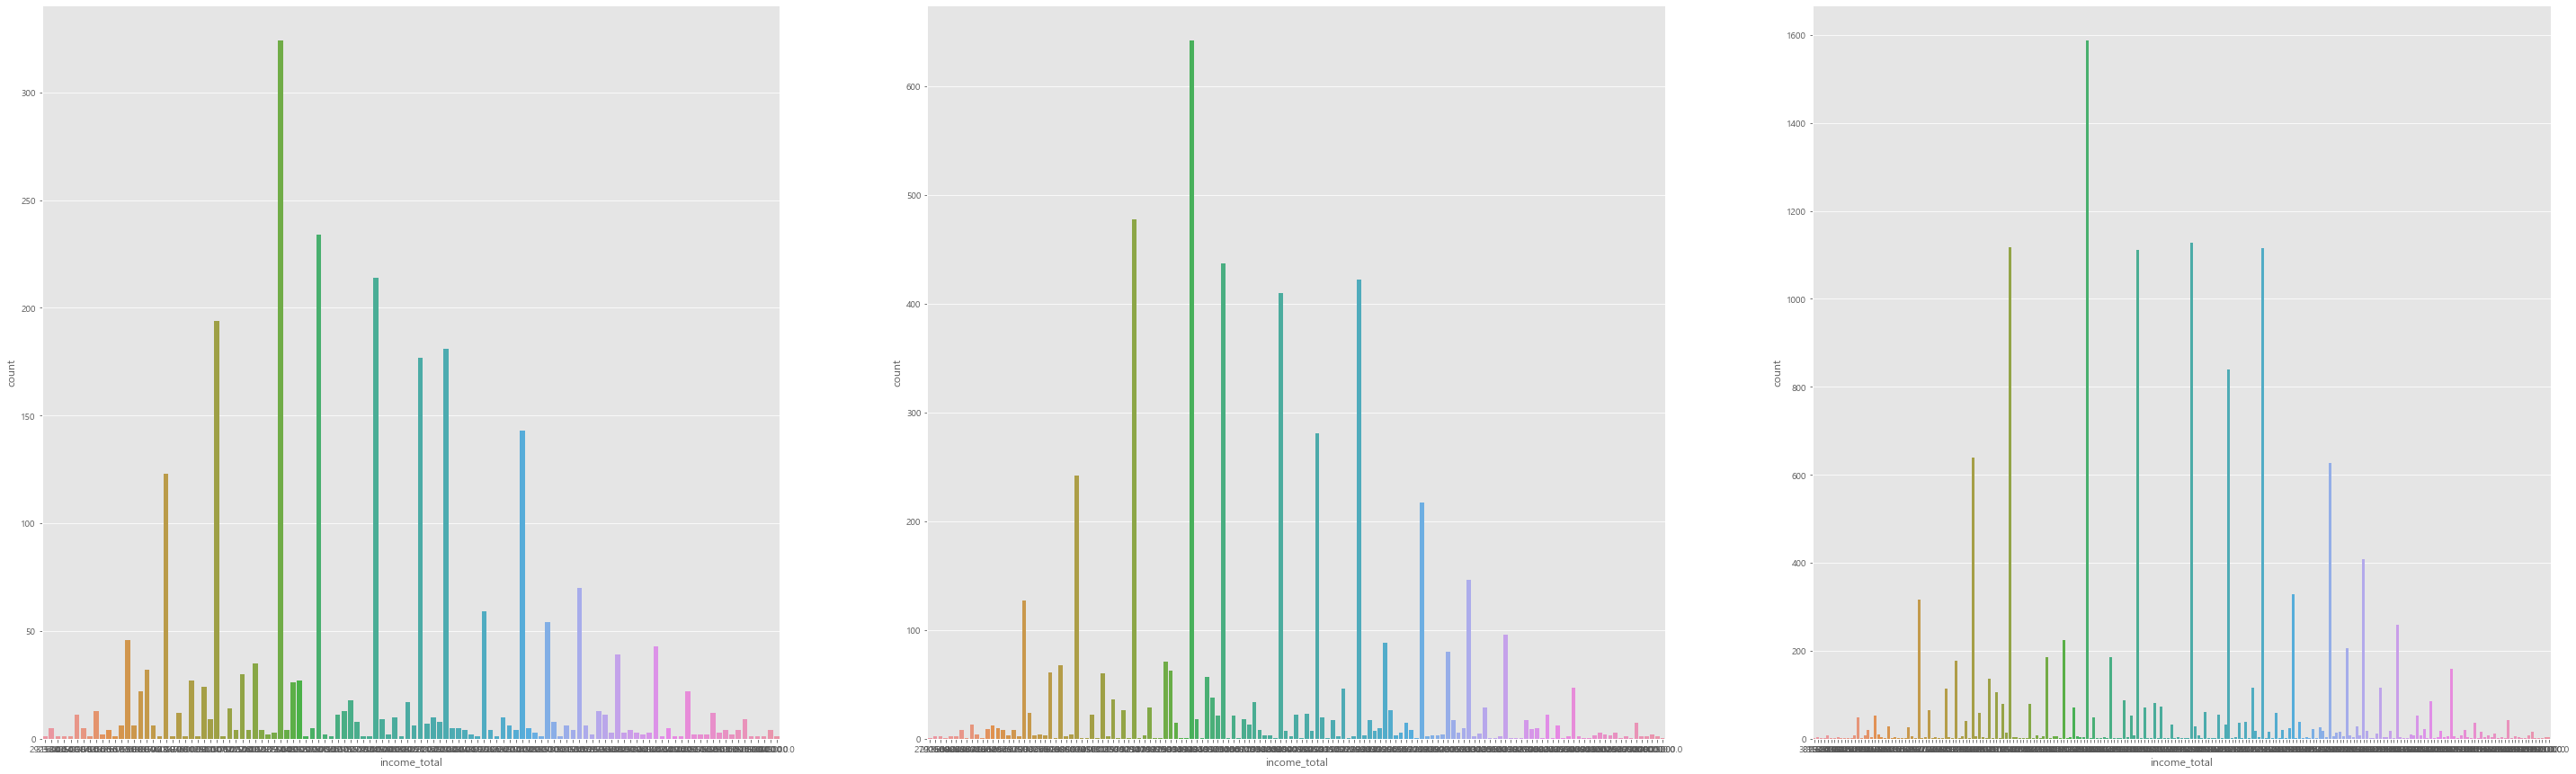

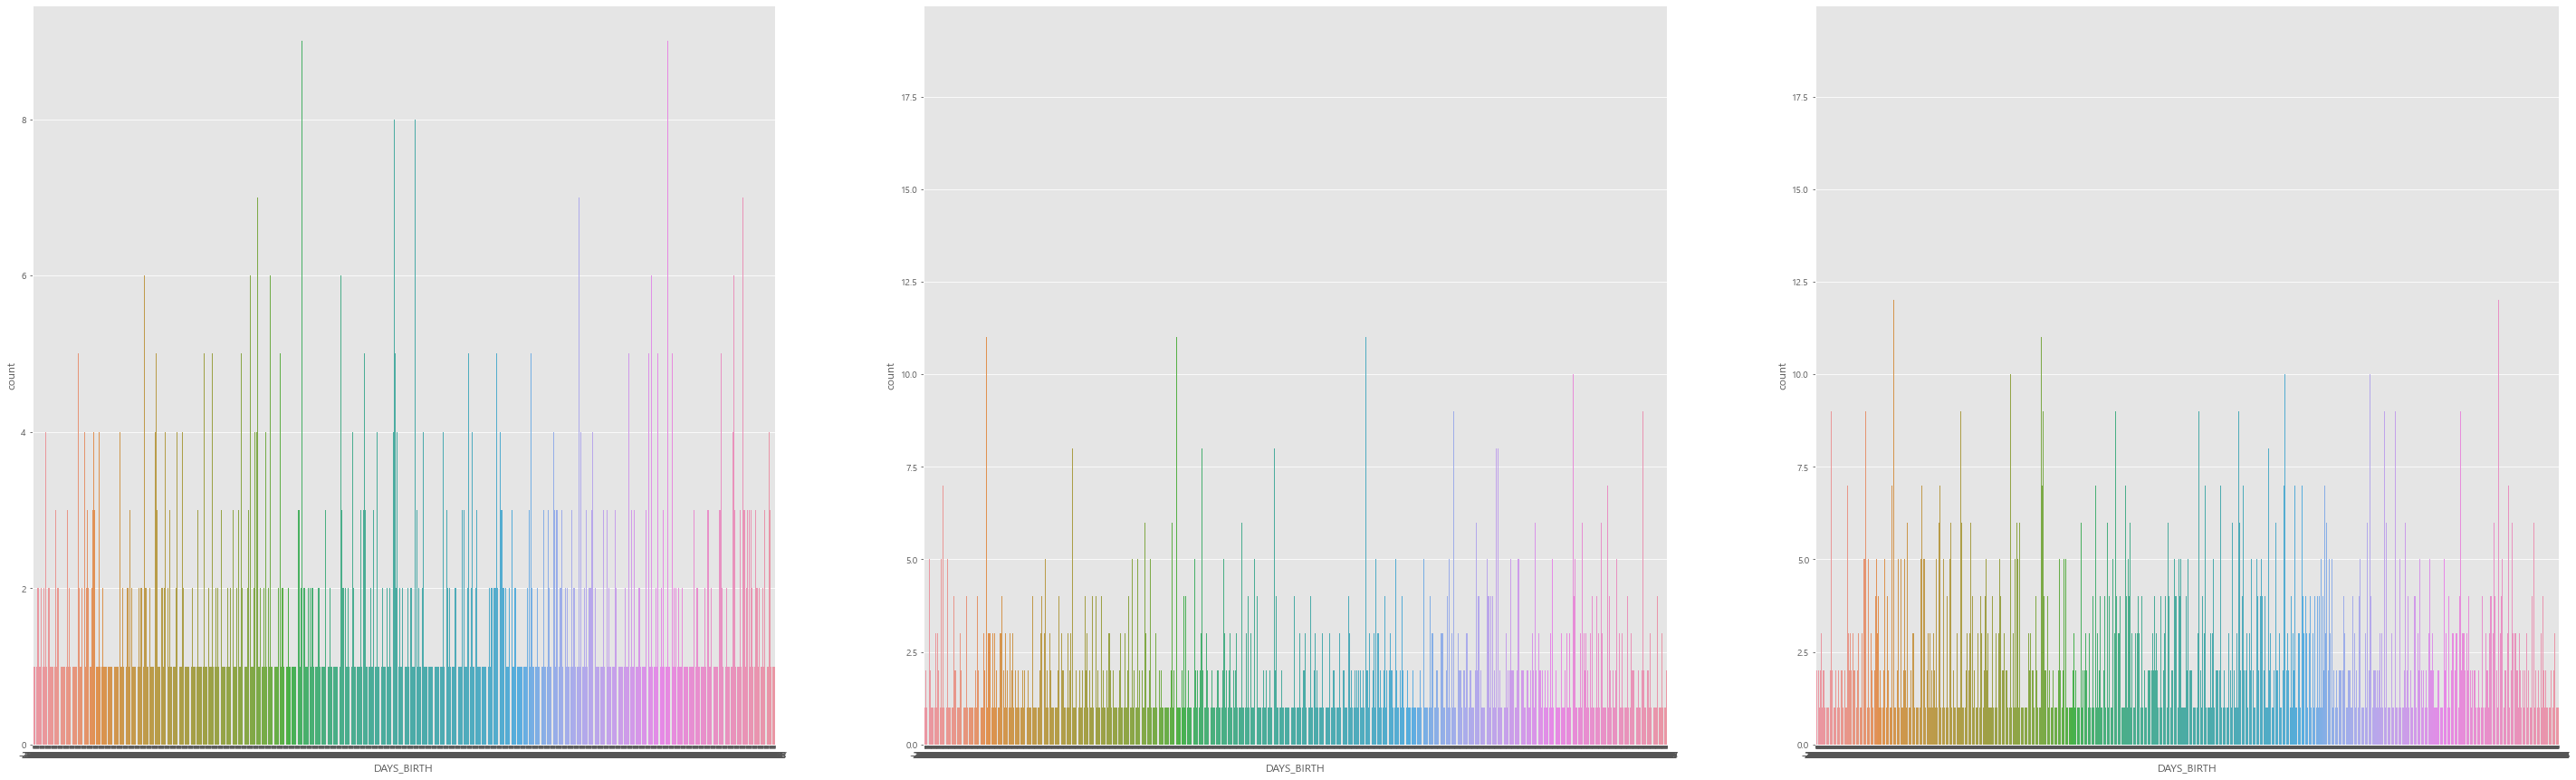

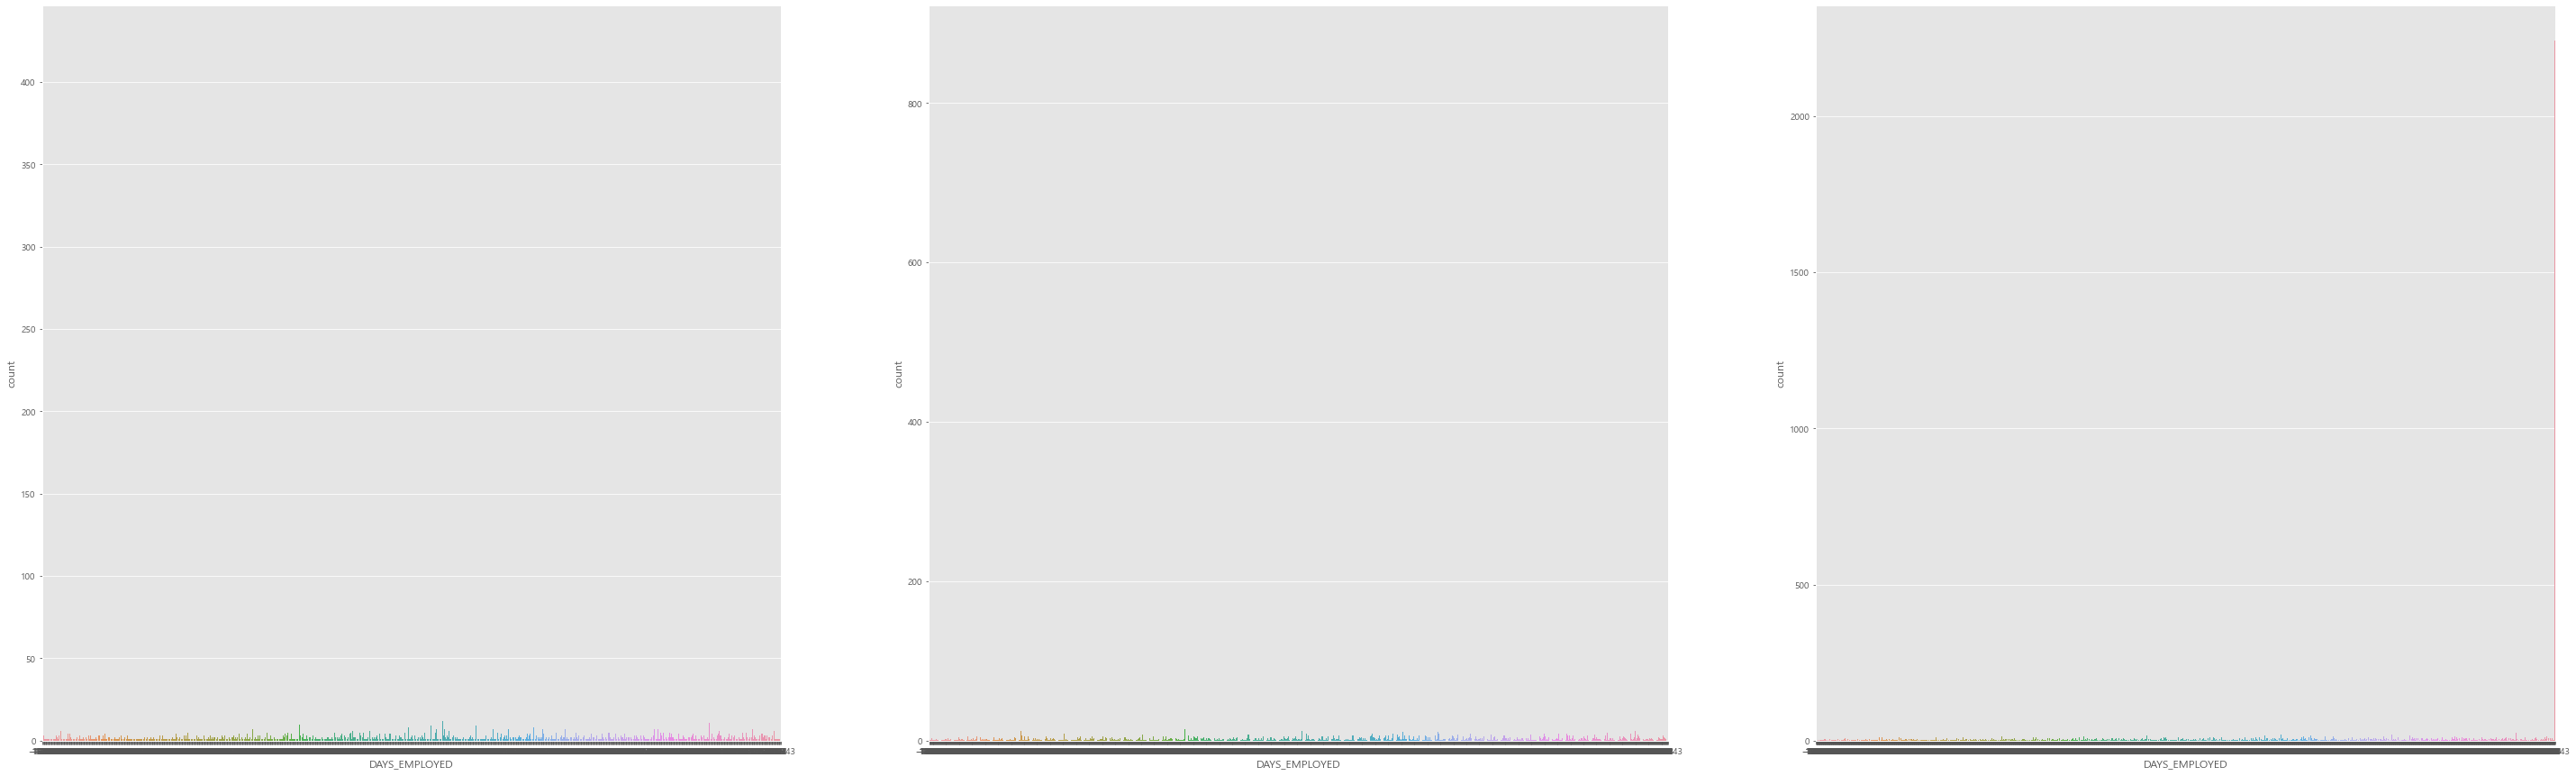

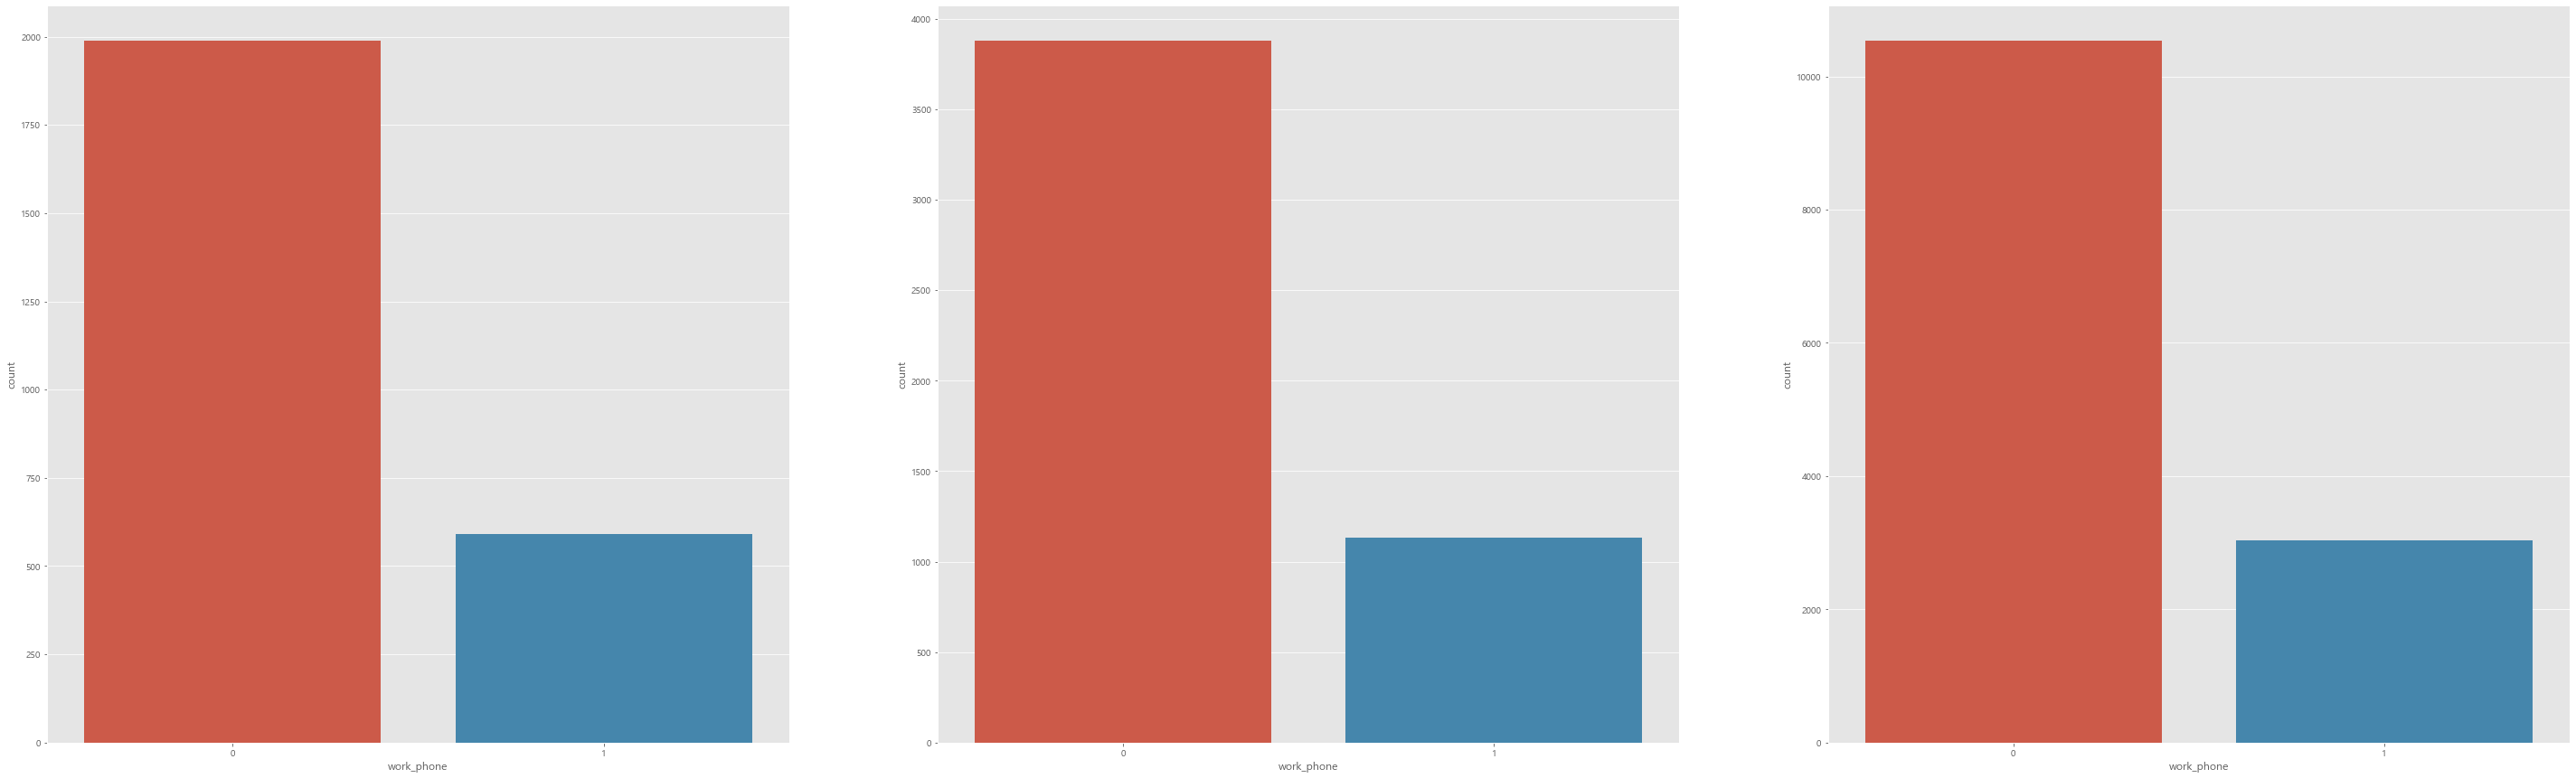

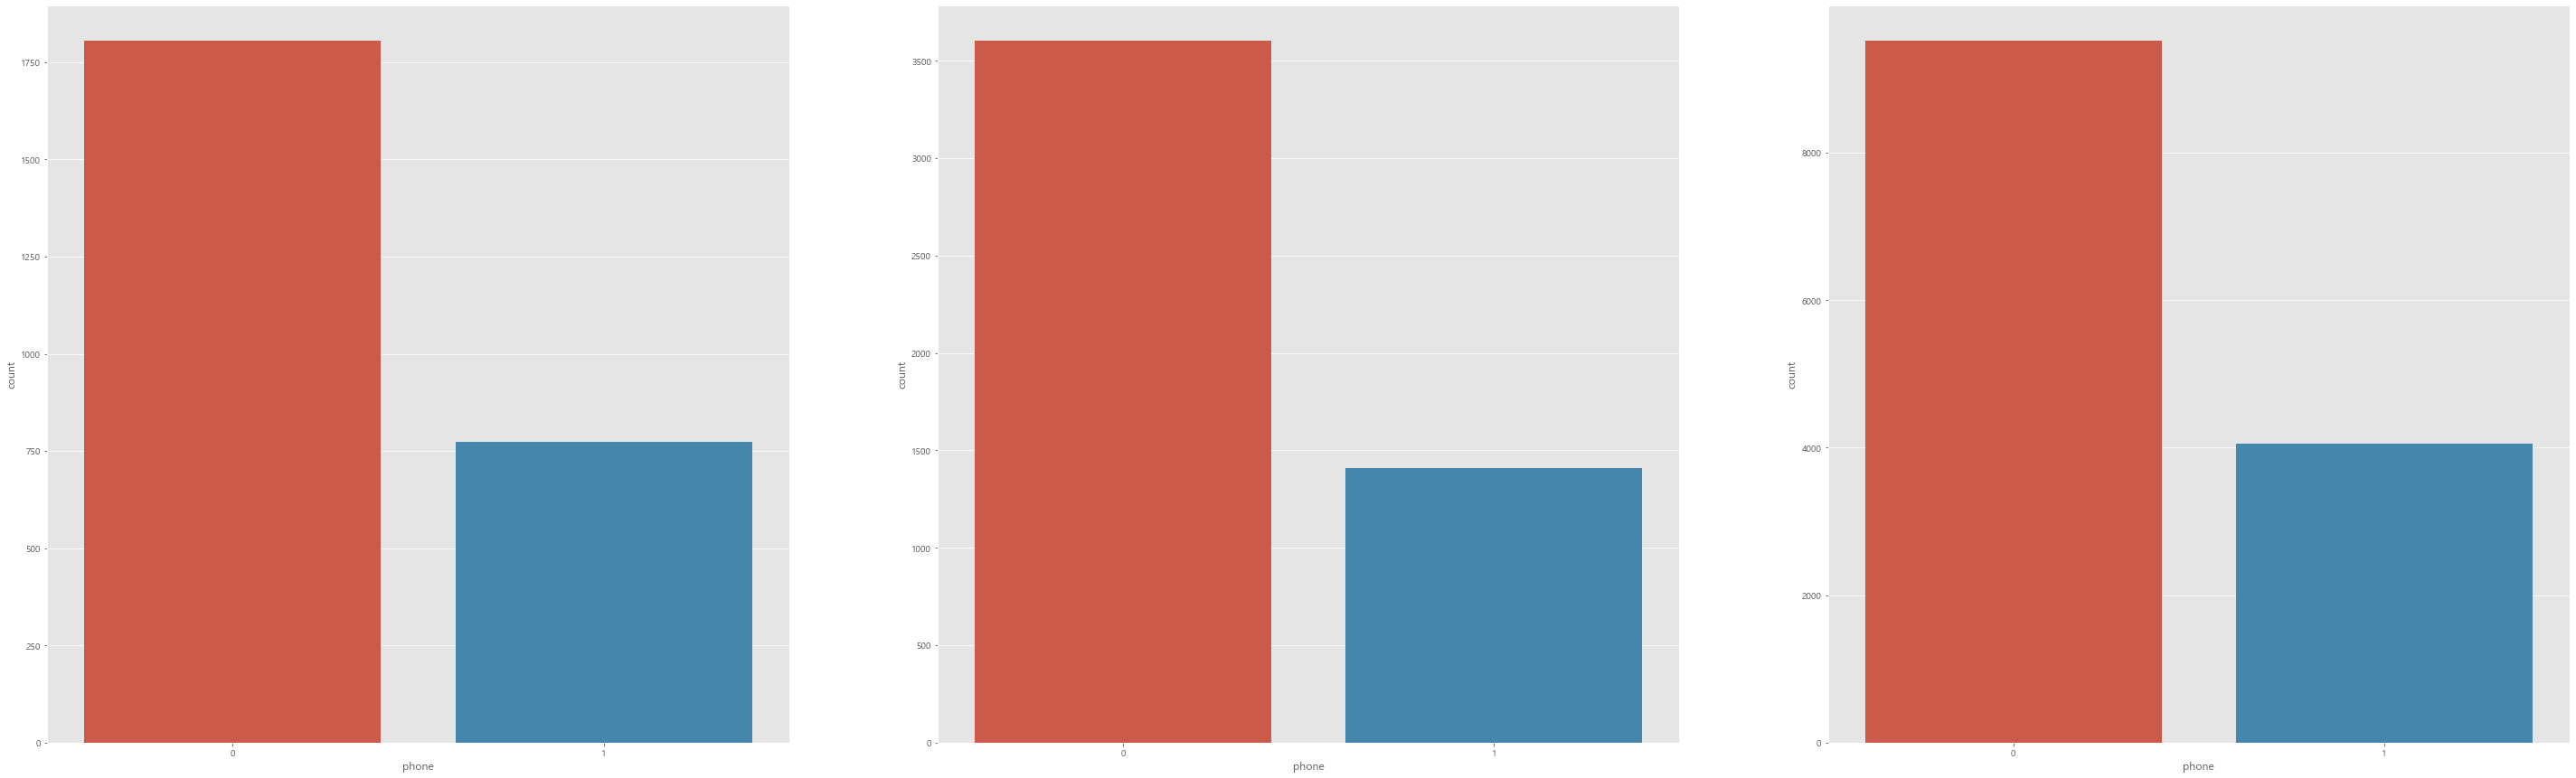

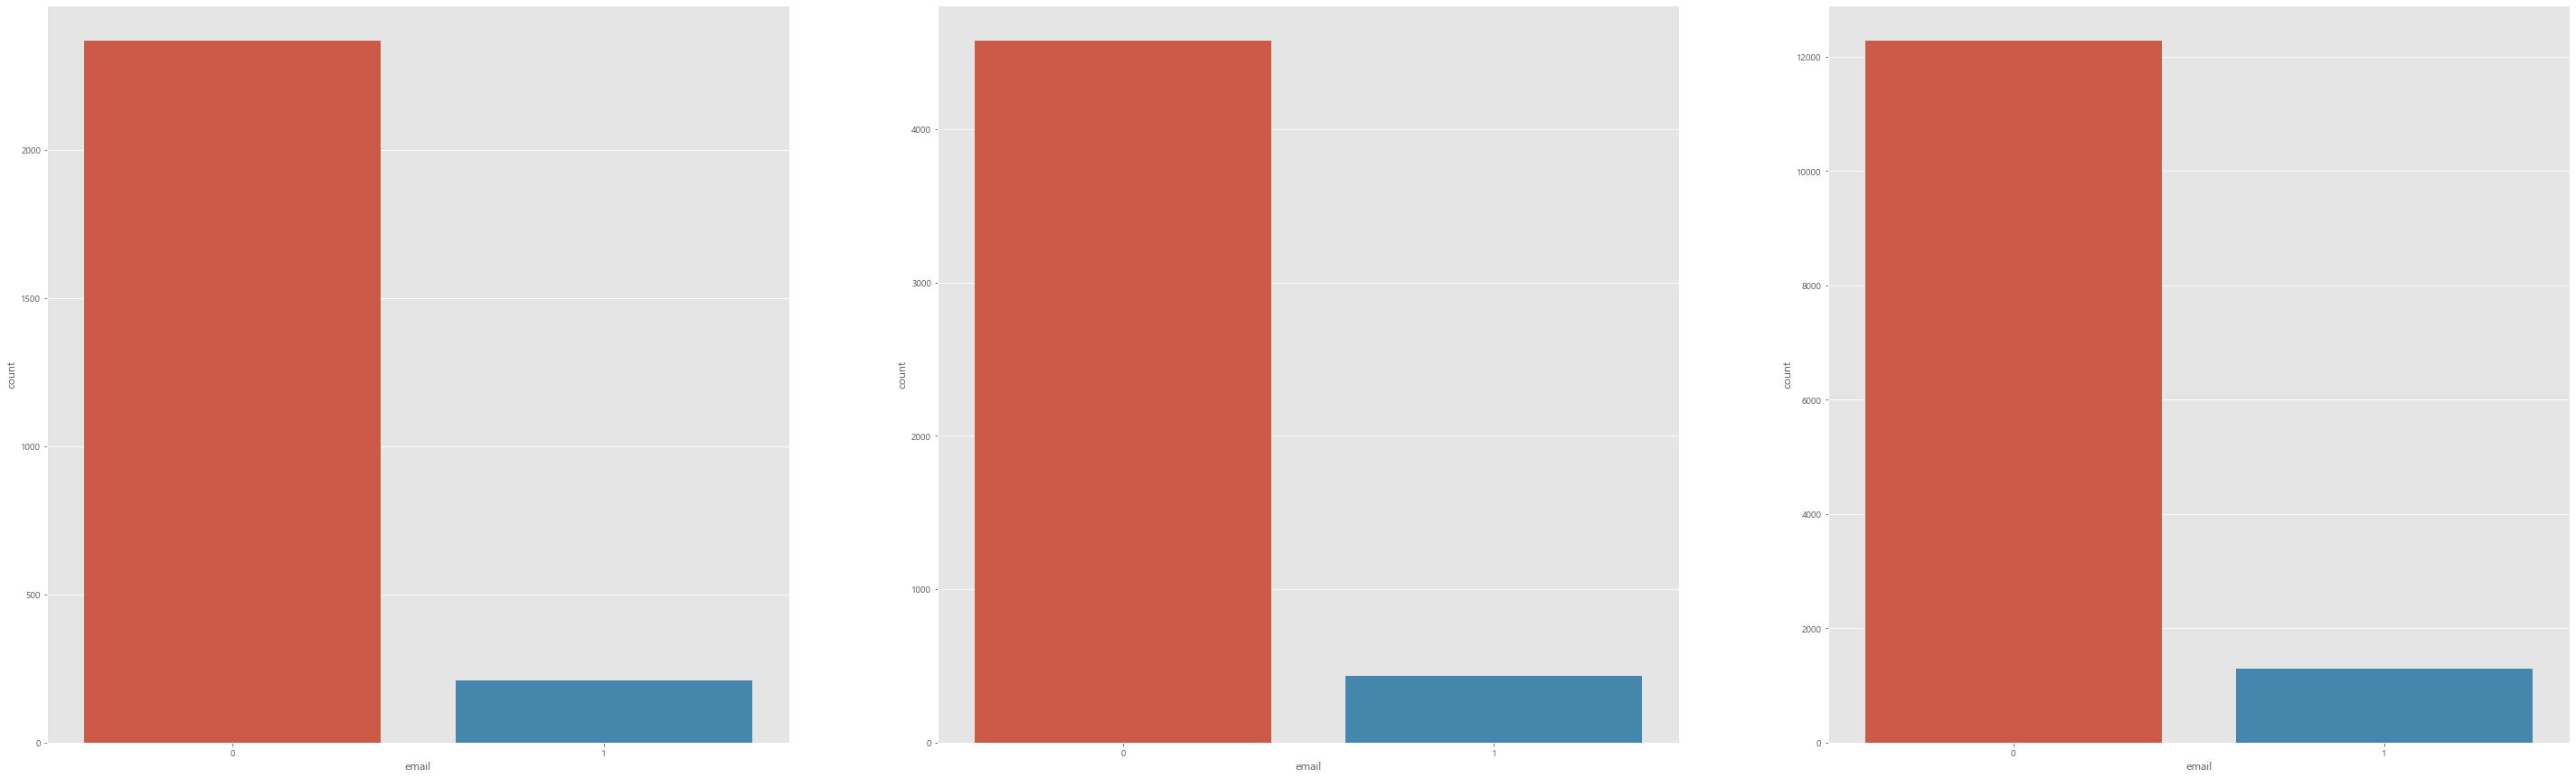

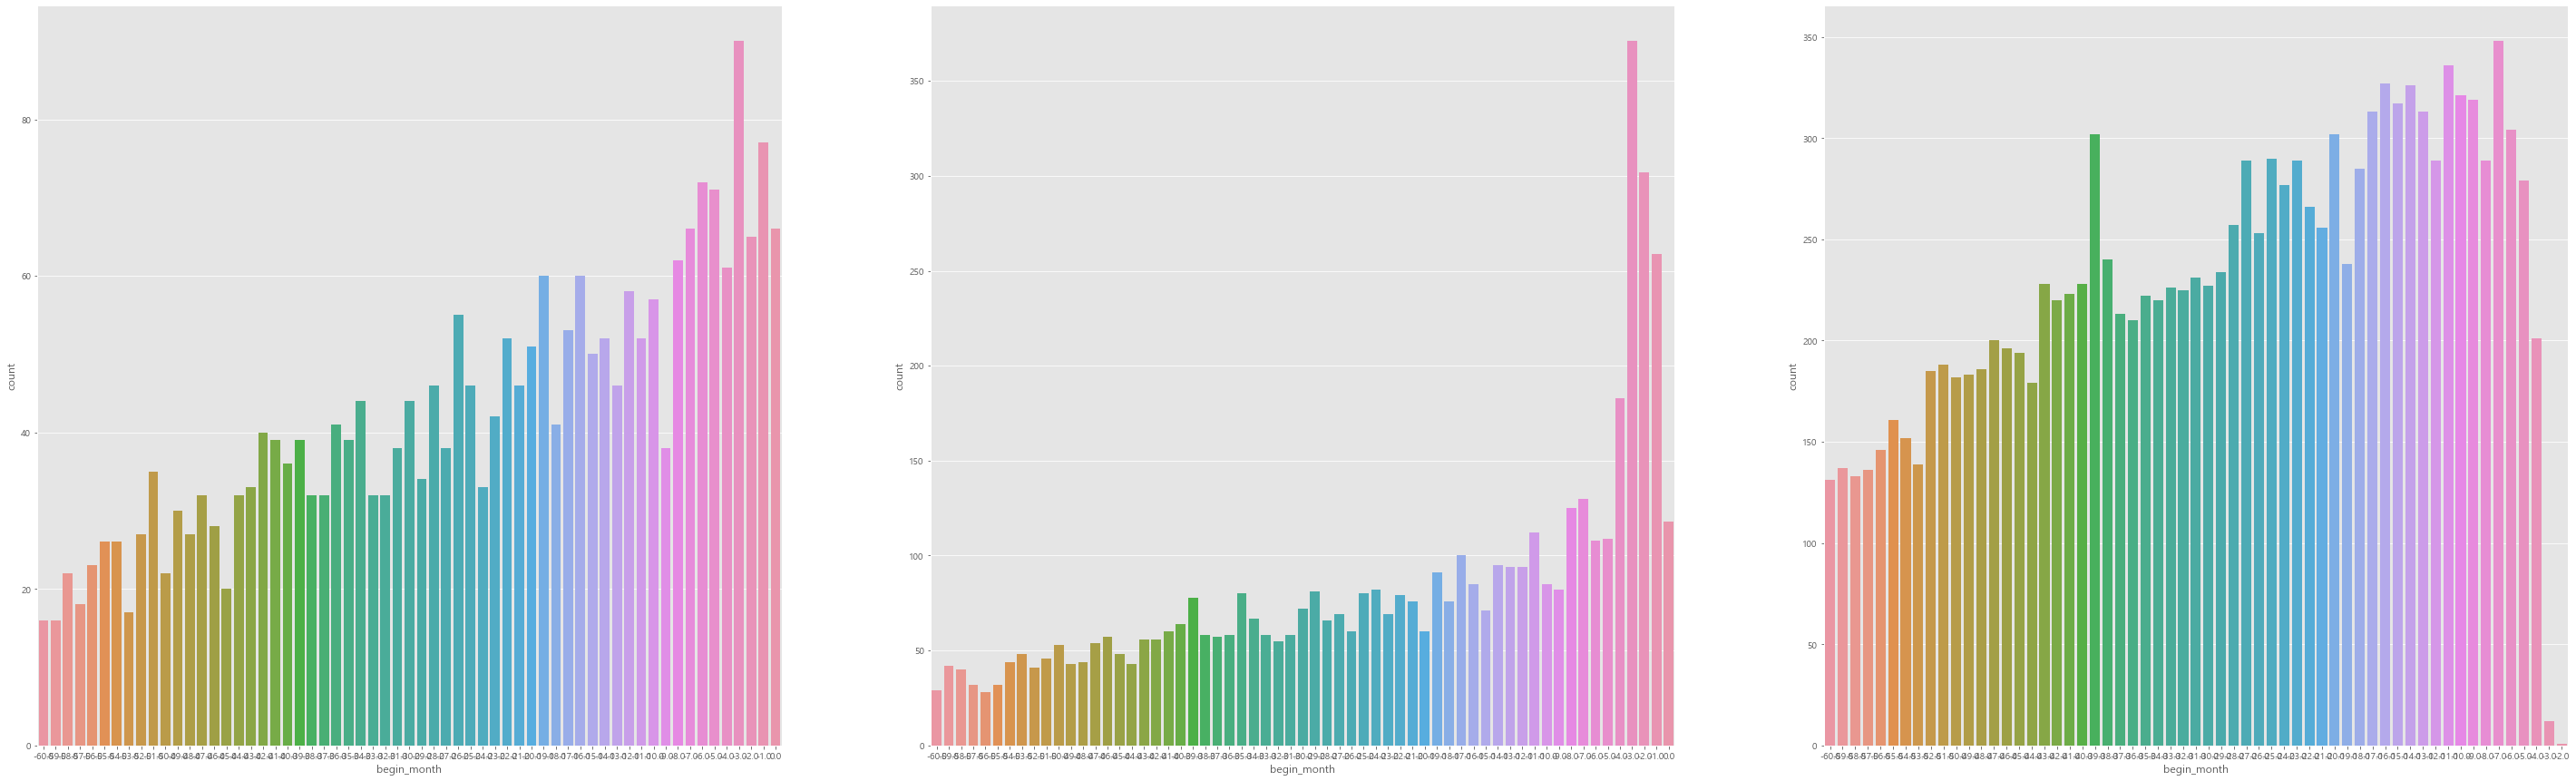

In [6]:
for feature in num:
    f, ax = plt.subplots(1,3,figsize=(50,15))
    sns.countplot(train[train['credit']==0][feature], data=train, ax=ax[0])
    sns.countplot(train[train['credit']==1][feature], data=train, ax=ax[1])
    sns.countplot(train[train['credit']==2][feature], data=train, ax=ax[2])

- credit별 연속형 변수들의 분포의 큰 차이를 발견할 수 없었다.

반면 **credit별 begin_month**를 살펴보자.

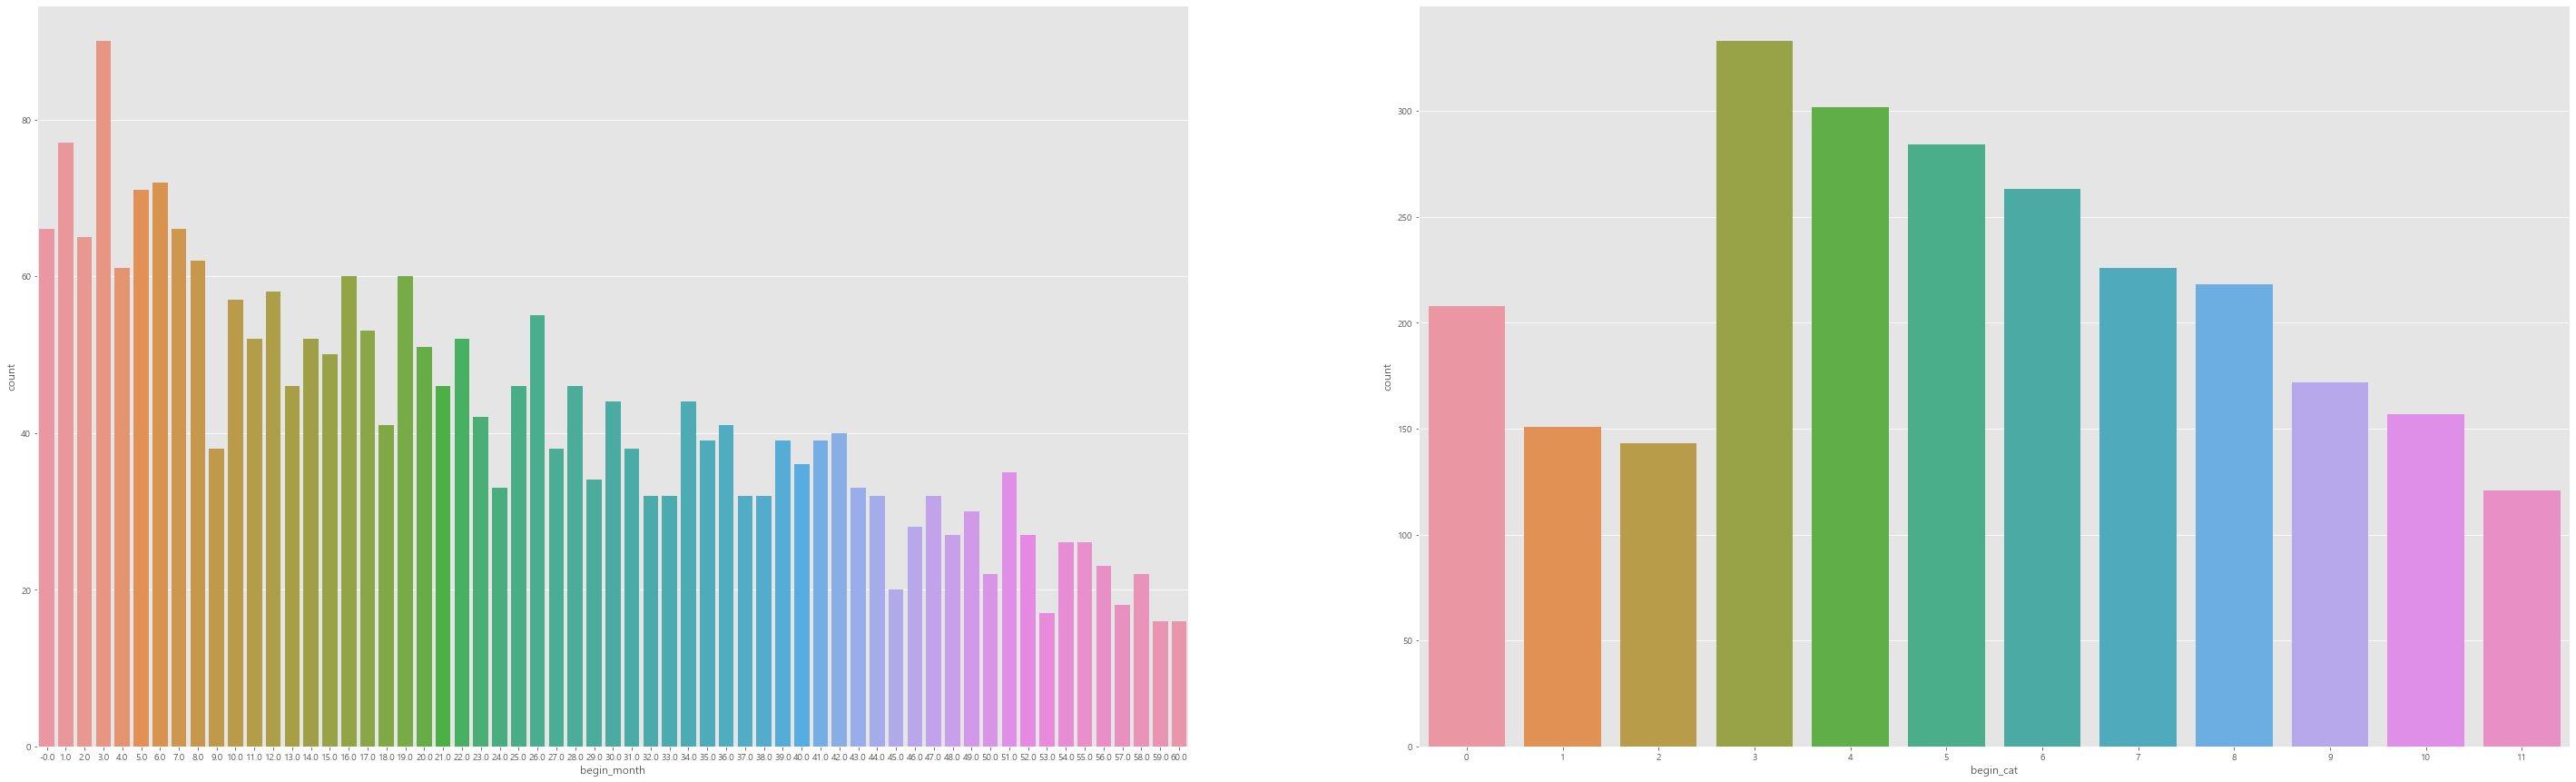

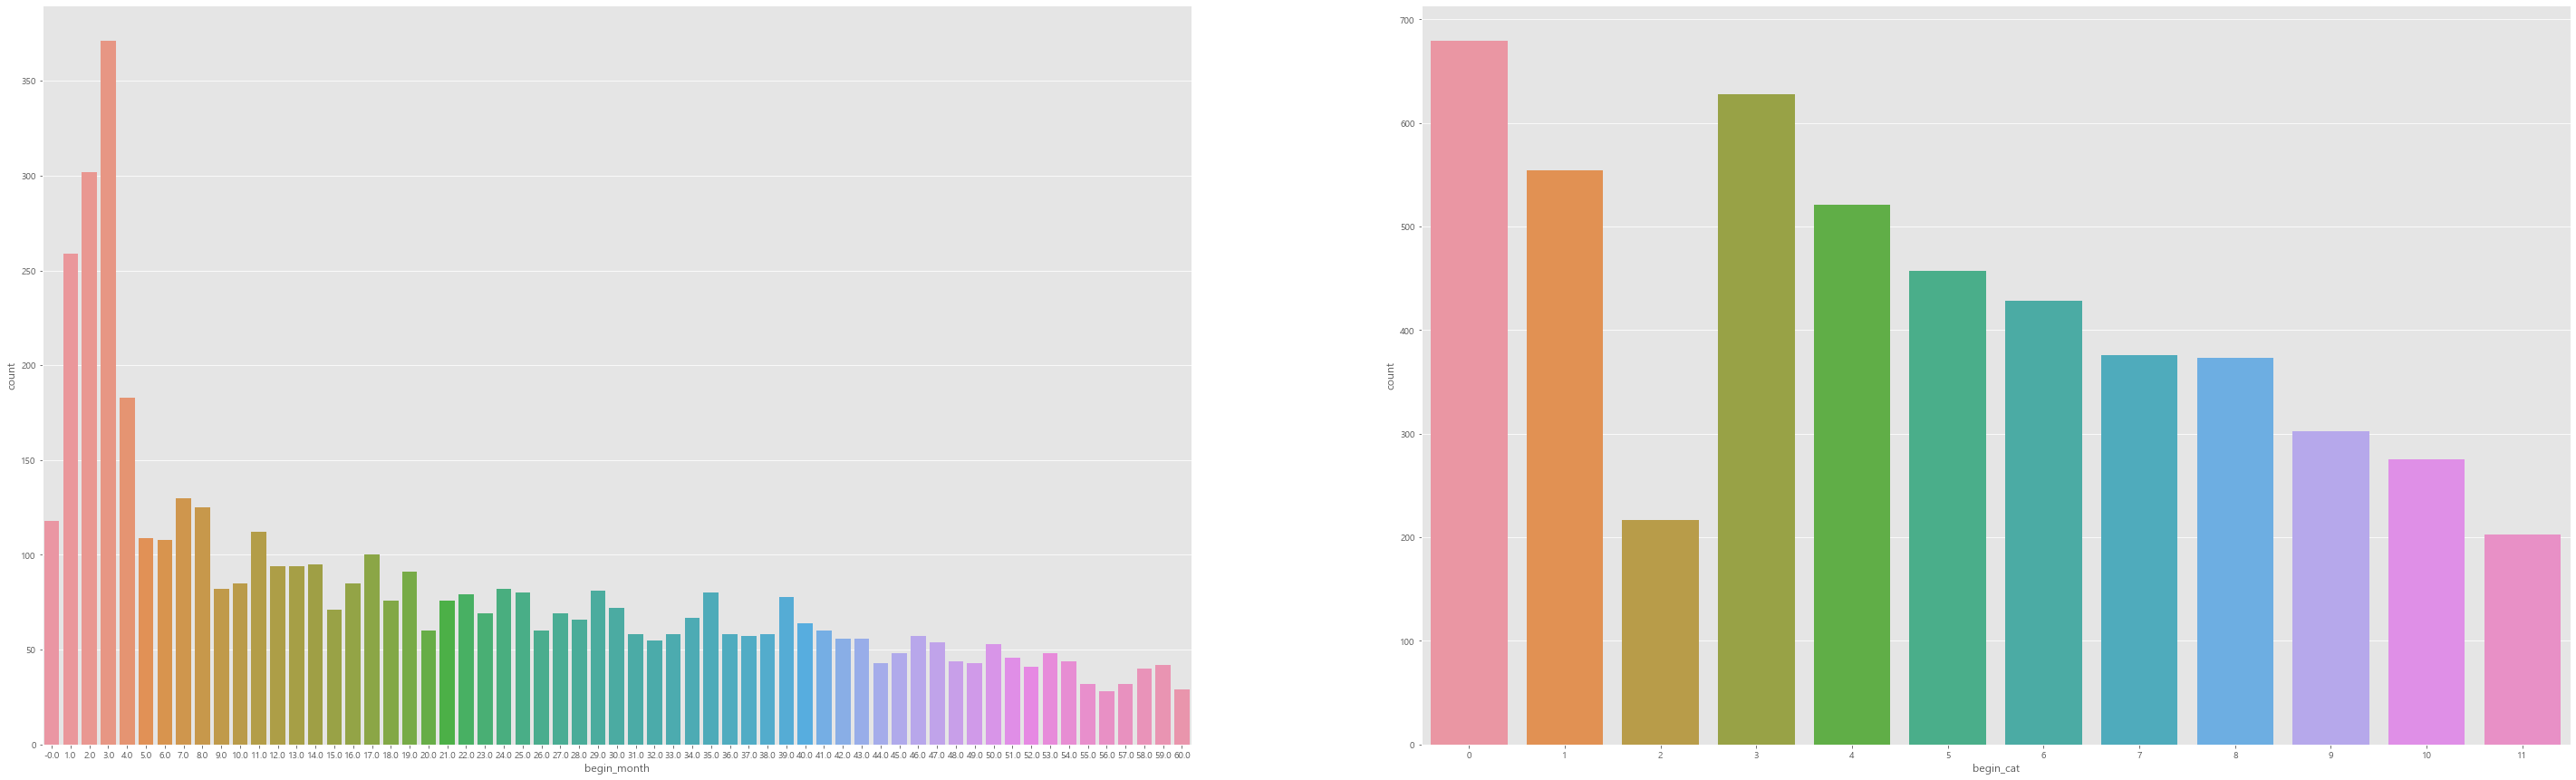

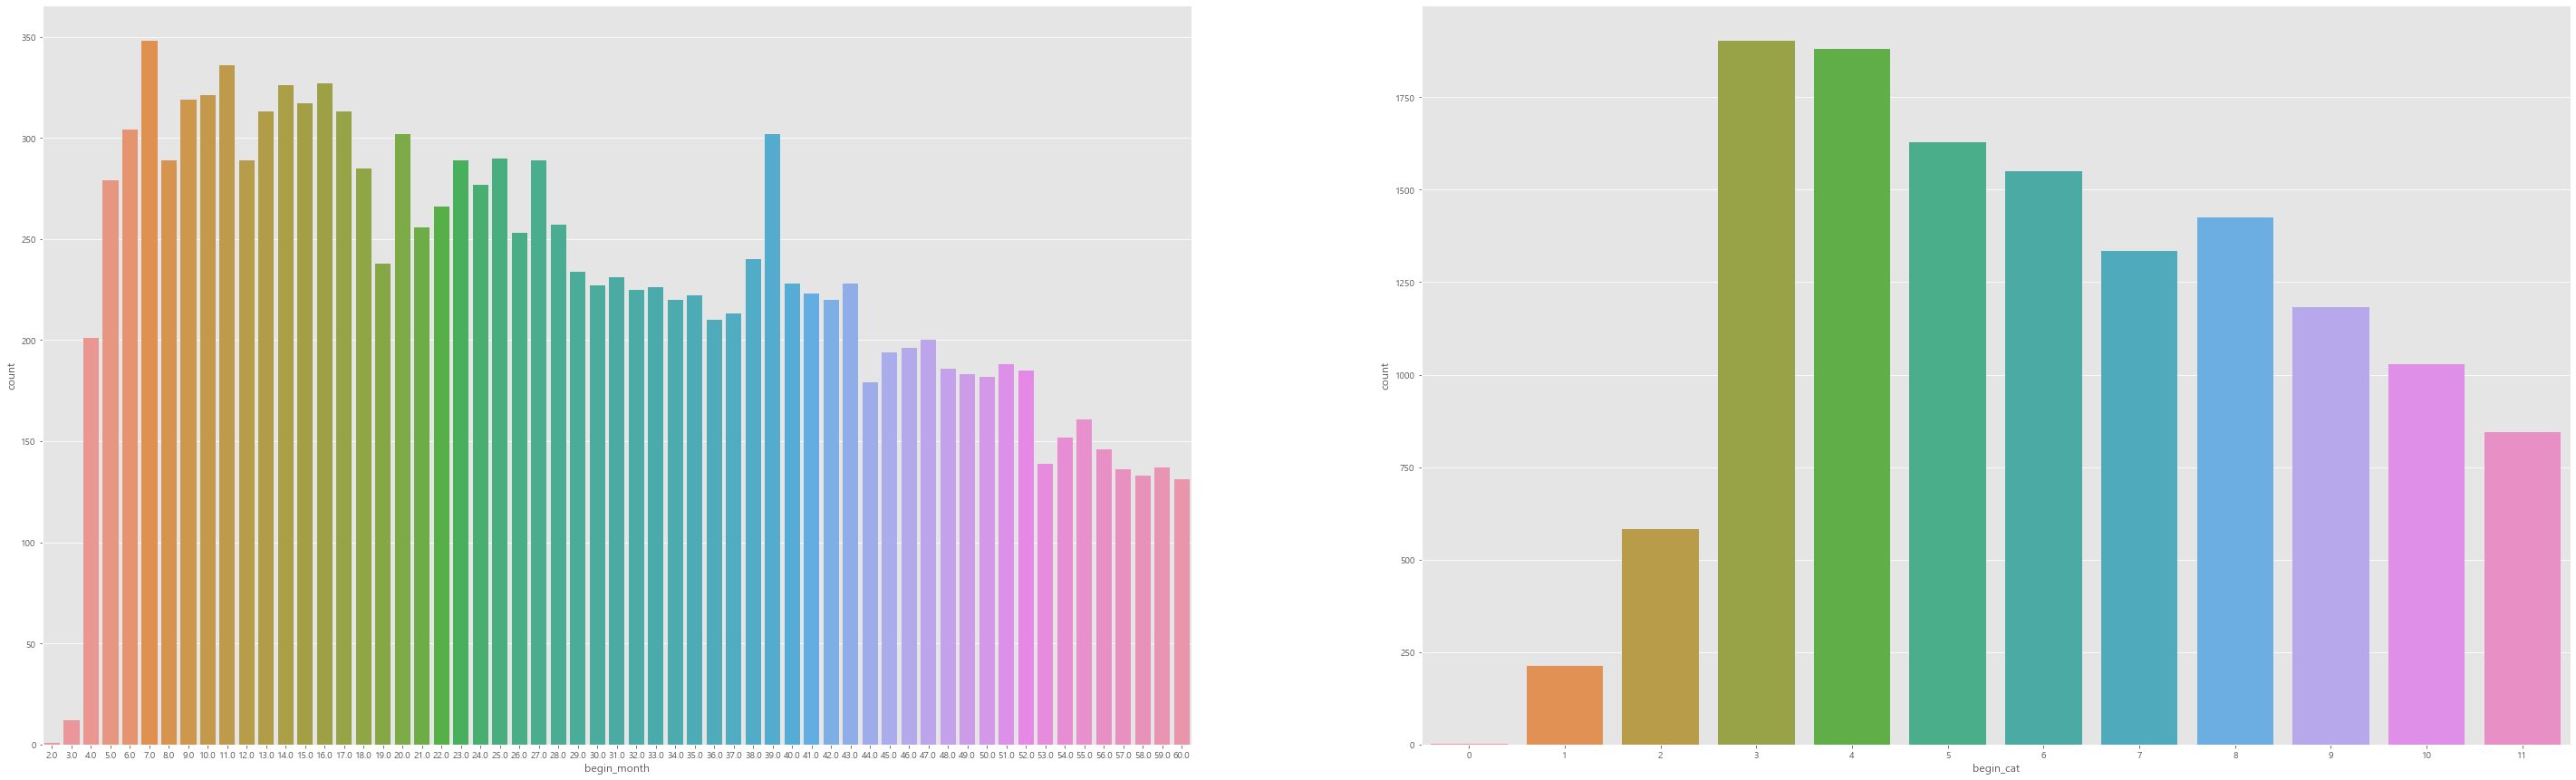

In [72]:
for i in range(0,3):
    f, ax = plt.subplots(1, 2, figsize=(50, 15))
    sns.countplot(train[train['credit']==i]['begin_month'], ax=ax[0])
    sns.countplot(train[train['credit']==i]['begin_cat'], ax=ax[1])
    plt.show()

- credit 0: begin_month 값이 골고루 퍼져 있다
- credit 1: begin_month 값이 작은 데이터가 상대적으로 많다
- credit 2: begin_month가 매우 작은 값이 거의 없고, begin_cat가 4 이상인 데이터가 많다.
<br>따라서, **begin_month**가 credit에 영향을 끼치는 유의미한 종속변수임을 알 수 있다!

# Data Preprocessing 

## 음수 Feature

DAYS_EMPLOYED, DAYS_BIRTH, begin_month 칼럼은 데이터 수집 당시 (0)부터 역으로 셈 → 양수로 바꿔줌

In [18]:
train['DAYS_EMPLOYED'] = -train['DAYS_EMPLOYED']
train['DAYS_BIRTH'] = -train['DAYS_BIRTH']
train['begin_month'] = -train['begin_month']

In [19]:
test['DAYS_EMPLOYED'] = -test['DAYS_EMPLOYED']
test['DAYS_BIRTH'] = -test['DAYS_BIRTH']
test['begin_month'] = -test['begin_month']

## 결측치 처리

In [20]:
train['occyp_type'].isnull().sum()

6549

'occyp_type'가 NULL인 데이터들의 'income_type'를 알아보자.

In [21]:
train[train['occyp_type'].isnull()].groupby('income_type')['income_type'].count()

income_type
Commercial associate     818
Pensioner               3546
State servant            319
Student                    1
Working                 1865
Name: income_type, dtype: int64

occyp_type이 NULL인 데이터 중 대다수가 Pensioner(연금 수령자)이다.
<br>따라서 해당 데이터들은 결측치가 아니라 실제로 직업이 없기 때문에 occyp_type이 비어 있는 것이라고 추정할 수 있다!
<br>→ 해당 데이터들을 삭제하지 않고 'NULL'으로 NULL 데이터를 채워주자.

In [22]:
train['occyp_type']= train['occyp_type'].fillna('NULL')
test['occyp_type']= test['occyp_type'].fillna('NULL')

## 이상치 처리

### DAYS_EMPLOYED

DAYS_EMPLOYED의 음수 데이터들을 살펴보자.

In [23]:
train[train['DAYS_EMPLOYED']<0].groupby('income_type')['income_type'].count()

income_type
Pensioner    3544
Name: income_type, dtype: int64

In [24]:
train[train['income_type']=='Pensioner'].groupby('DAYS_EMPLOYED')['DAYS_EMPLOYED'].count()

DAYS_EMPLOYED
-365243    3544
 586          1
 620          1
 672          1
 673          1
 1325         1
 5521         1
Name: DAYS_EMPLOYED, dtype: int64

연금수령자인 사람 = DAYS_EMPLOYED가 -365243인 사람
<br>따라서 이들은 현재 일을 하지 않는 사람들이므로 DAYS_EMPLOYED를 0으로 채워주자.

In [25]:
train.loc[train['DAYS_EMPLOYED']<0, 'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED']<0, 'DAYS_EMPLOYED'] = 0

### child_num

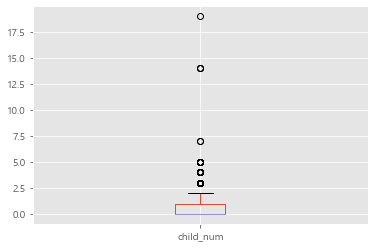

In [26]:
train[['child_num']].boxplot()
plt.show()

In [27]:
train['child_num'].value_counts()

0     14699
1      4331
2      1853
3       237
4        31
5         8
14        3
7         2
19        1
Name: child_num, dtype: int64

In [28]:
test['child_num'].value_counts()

0    3641
1    1055
2     509
3      69
4      16
5       2
Name: child_num, dtype: int64

childnum이 지나치게 큰 데이터가 존재한다 → 이상치로 판단
<br>7이 넘는 이상치들을 7로 채워주자.

In [29]:
train.loc[train['child_num']>7, 'child_num'] =7
test.loc[test['child_num']>7, 'child_num'] =7

### family_size

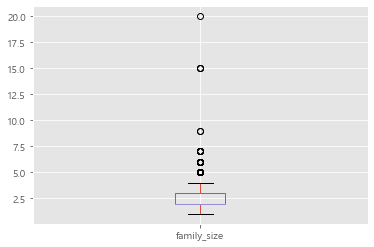

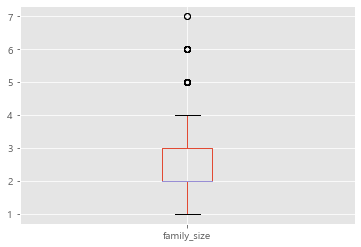

In [30]:
train[['family_size']].boxplot()
plt.show()
test[['family_size']].boxplot()
plt.show()

In [31]:
train[['family_size']].value_counts()

family_size
2.0            11280
1.0             4123
3.0             3717
4.0             1781
5.0              221
6.0               30
7.0                7
15.0               3
9.0                2
20.0               1
dtype: int64

child_num에서의 최댓값 7 + 부모 2 = 9  
family_size의 이상치를 9로 처리해주자.<br>
9 이상일 경우 9로 값을 변경했다.

In [32]:
train.loc[train['family_size']>9, 'family_size'] = 9
test.loc[train['family_size']>9, 'family_size'] = 9

## Drop value

### FLAG_MOBIL

In [33]:
train['FLAG_MOBIL'].value_counts()

1    21165
Name: FLAG_MOBIL, dtype: int64

In [34]:
test['FLAG_MOBIL'].value_counts()

1    5292
Name: FLAG_MOBIL, dtype: int64

모든 데이터의 FLAG_MOBIL 값이 1로 채워져 있다.
<br>의미가 없는 데이터이기에 칼럼 전체를 삭제하자.

In [35]:
train.drop(['FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['FLAG_MOBIL'], axis=1, inplace=True)

# Feature Engineering

## begin_cat

전체적으로 begin_moth가 클수록 credit이 높아지는 경항성을 보인다.
<br>credit을 결정함에 있어서 중요한 칼럼으로 판단되어 begin_moth를 12개 구간으로 나눈 begin_cat 칼럼을 추가해주었다

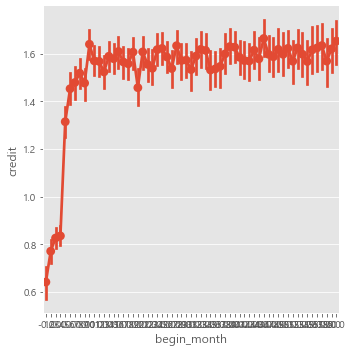

In [36]:
sns.factorplot(x='begin_month', y='credit',data=train)
plt.show()

In [37]:
train['begin_cat'] = -100
train['begin_cat'] = -100

train['begin_cat'] = pd.cut(train['begin_month'], bins=[-1, 2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54, 61], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
test['begin_cat'] = pd.cut(test['begin_month'], bins=[-1, 2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54, 61], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [38]:
train['begin_cat'] = train.begin_cat.astype('int')
test['begin_cat'] = test.begin_cat.astype('int')

## ID

In [39]:
train.sort_values(by=['DAYS_BIRTH', 'begin_month']).head(3)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,begin_cat
14789,2764,M,N,N,0,180000.0,Working,Incomplete higher,Civil marriage,With parents,7705,288,1,0,1,Core staff,2.0,4.0,2.0,1
10312,20255,M,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,7723,366,0,0,1,Sales staff,1.0,-0.0,1.0,0
12783,21751,M,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,7723,366,0,0,1,Sales staff,1.0,-0.0,1.0,0


아래쪽 두 데이터를 보면, 개인 신상에 관련된 정보들이 정확하게 일치한다.
<br>따라서 **같은 사람**이라고 판단할 수 있다!
<br>같은 사람인지 아닌지를 판단하기 위한 ID 칼럼을 추가해주었다.

In [40]:
train['personal_id'] = \
    train['child_num'].astype(str) + '_' + train['income_total'].astype(str) + '_' +\
    train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' +\
    train['work_phone'].astype(str) + '_' + train['phone'].astype(str) + '_' +\
    train['email'].astype(str) + '_' + train['family_size'].astype(str) + '_' +\
    train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' +\
    train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' +\
    train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' +\
    train['house_type'].astype(str) + '_' + train['occyp_type'].astype(str)

train['personal_id_begin'] =\
    train['child_num'].astype(str) + '_' + train['income_total'].astype(str) + '_' +\
    train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' +\
    train['work_phone'].astype(str) + '_' + train['phone'].astype(str) + '_' +\
    train['email'].astype(str) + '_' + train['family_size'].astype(str) + '_' +\
    train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' +\
    train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' +\
    train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' +\
    train['house_type'].astype(str) + '_' + train['occyp_type'].astype(str)+train['begin_month'].astype(str)

In [41]:
test['personal_id'] = \
    test['child_num'].astype(str) + '_' + test['income_total'].astype(str) + '_' +\
    test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' +\
    test['work_phone'].astype(str) + '_' + test['phone'].astype(str) + '_' +\
    test['email'].astype(str) + '_' + test['family_size'].astype(str) + '_' +\
    test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' +\
    test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' +\
    test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' +\
    test['house_type'].astype(str) + '_' + test['occyp_type'].astype(str)

test['personal_id_begin'] =\
    test['child_num'].astype(str) + '_' + test['income_total'].astype(str) + '_' +\
    test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' +\
    test['work_phone'].astype(str) + '_' + test['phone'].astype(str) + '_' +\
    test['email'].astype(str) + '_' + test['family_size'].astype(str) + '_' +\
    test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' +\
    test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' +\
    test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' +\
    test['house_type'].astype(str) + '_' + test['occyp_type'].astype(str)+test['begin_month'].astype(str)


## 중복 데이터 처리

In [42]:
dup = train[train.duplicated('DAYS_BIRTH')].sort_values(['DAYS_BIRTH'])[['DAYS_BIRTH', 'begin_month', 'credit']].head(9)

def draw_color_cell(x,color):
    color = f'background-color:{color}'
    return color

In [43]:
dup.style.applymap(draw_color_cell,color='#ff9090',subset=pd.IndexSlice[2705:9773,:])

,DAYS_BIRTH,begin_month,credit
12783,7723,-0.000000,1.000000
2705,7757,2.000000,0.000000
9773,7757,13.000000,1.000000
8016,8056,11.000000,2.000000
17883,8107,6.000000,2.000000
5364,8107,24.000000,2.000000
12189,8189,5.000000,1.000000
12357,8189,1.000000,1.000000
14199,8213,21.000000,2.000000


DAYS_BIRTH를 포함한 다른 feature의 값은 동일하지만 begin_month와 credit의 값만 다른 행들을 관찰할 수 있다.<br>
이를 동일한 사람이 **신용카드를 여러 번 발급받은 것** 이라고 해석할 수 있다. <br>
(위 데이터프레임에서 한 사람이 13개월 전과 2개월 전 카드를 두 번 발급받은 것! 이에 따라 신용도도 변화하였음)

In [44]:
dup.style.applymap(draw_color_cell,color='#CBADD0',subset=pd.IndexSlice[17883:5364,:])

,DAYS_BIRTH,begin_month,credit
12783,7723,-0.000000,1.000000
2705,7757,2.000000,0.000000
9773,7757,13.000000,1.000000
8016,8056,11.000000,2.000000
17883,8107,6.000000,2.000000
5364,8107,24.000000,2.000000
12189,8189,5.000000,1.000000
12357,8189,1.000000,1.000000
14199,8213,21.000000,2.000000


카드를 여러 번 발급받았지만 신용도가 변화하지 않는 사람도 존재한다

### cardnum

같은 ID를 가진 사람이 카드를 몇 번 발급 받았는지를 의미하는 변수
- 카드 한 번 발급(신규 회원인 경우): cardnum = 0
- 카드 두 번 발급: cardnum = 1

In [45]:
train_dup = train.sort_values(by=['DAYS_BIRTH', 'begin_month'])
test_dup = test.sort_values(by=['DAYS_BIRTH', 'begin_month'])

train_dup['cardnum'] = 0
test_dup['cardnum'] = 0


In [46]:
temp = 0
cardnum = 0
for i in range(len(train_dup)):
    if temp != train_dup.iloc[i,-3]: # 신규 회원인 경우
        temp = train_dup.iloc[i, -3]
        cardnum = 0
    else:
        cardnum += 1
        train_dup.iloc[i,-1] = cardnum

In [47]:
temp = 0
cardnum = 0
for i in range(len(test_dup)):
    if temp != test_dup.iloc[i,-3]: # 신규 회원인 경우
        temp = test_dup.iloc[i, -3]
        cardnum = 0
    else:
        cardnum += 1
        test_dup.iloc[i,-1] = cardnum

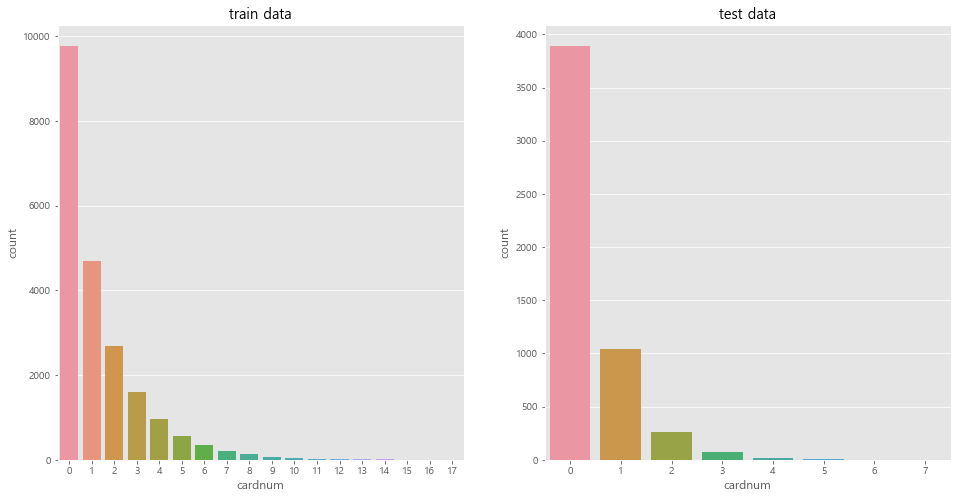

In [48]:
f, ax = plt.subplots(1, 2, figsize=(16,8))

sns.countplot('cardnum',data=train_dup,ax=ax[0])
ax[0].set_title('train data')

sns.countplot('cardnum',data=test_dup,ax=ax[1])
ax[1].set_title('test data')


plt.show()

- cardnum이 0이 아닌 데이터들도 많이 존재한다.
- train data와 test data 모두 cardnum이 0인 고객들이 가장 많고, cardnum이 클수록 해당 고객의 수가 줄어든다.

### change

카드 발급 횟수에 따라 신규 회원인지를 구분하는 변수
- 신규 회원인 경우: change = 0
- 기존 회원인 경우: change = 1

In [49]:
train_dup['change'] = 0
train_dup.loc[train_dup['cardnum']>0, 'change'] = 1
train = train_dup.sort_values('index').sort_index()

In [50]:
test_dup['change'] = 0
test_dup.loc[test_dup['cardnum']>0, 'change'] = 1
test = test_dup.sort_values('index').sort_index()

In [51]:
train[['personal_id', 'begin_month', 'change', 'cardnum']].sort_values('personal_id').head(3)

,personal_id,begin_month,change,cardnum
3011,0_101250.0_22059_0_0_1_0_1.0_F_N_Y_Pensioner_S...,2.0,0,0
7919,0_101250.0_22059_0_0_1_0_1.0_F_N_Y_Pensioner_S...,2.0,1,1
4588,0_101250.0_22059_0_0_1_0_1.0_F_N_Y_Pensioner_S...,3.0,1,2


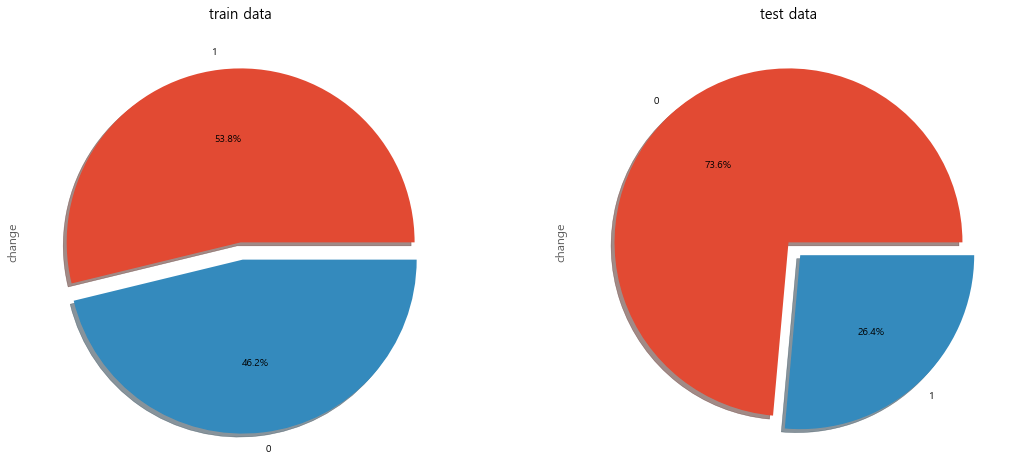

In [52]:
f, ax = plt.subplots(1, 2, figsize=(18,8))

train['change'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('train data')

test['change'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%',ax=ax[1],shadow=True)
ax[1].set_title('test data')

plt.show()

- train data의 경우 신규회원과 기존회원의 수가 비슷하다
- test data의 경우 신규 회원의 수가 비교적 많다

# Label Encoding

In [53]:
categorical = train.select_dtypes(object).columns
categorical

label = preprocessing.LabelEncoder()
train_processed = pd.DataFrame() 
test_processed = pd.DataFrame() 

for i in train.columns :
    if i in categorical :
        train_processed[i]=label.fit_transform(train[i])
        test_processed[i]=label.fit_transform(test[i])
    elif i == 'credit' :
        train_processed[i]=train[i]
    else :
        train_processed[i]=train[i]
        test_processed[i]=test[i]

train = train_processed
test = test_processed

In [54]:
train = train_processed
test = test_processed

# 상관관계 확인

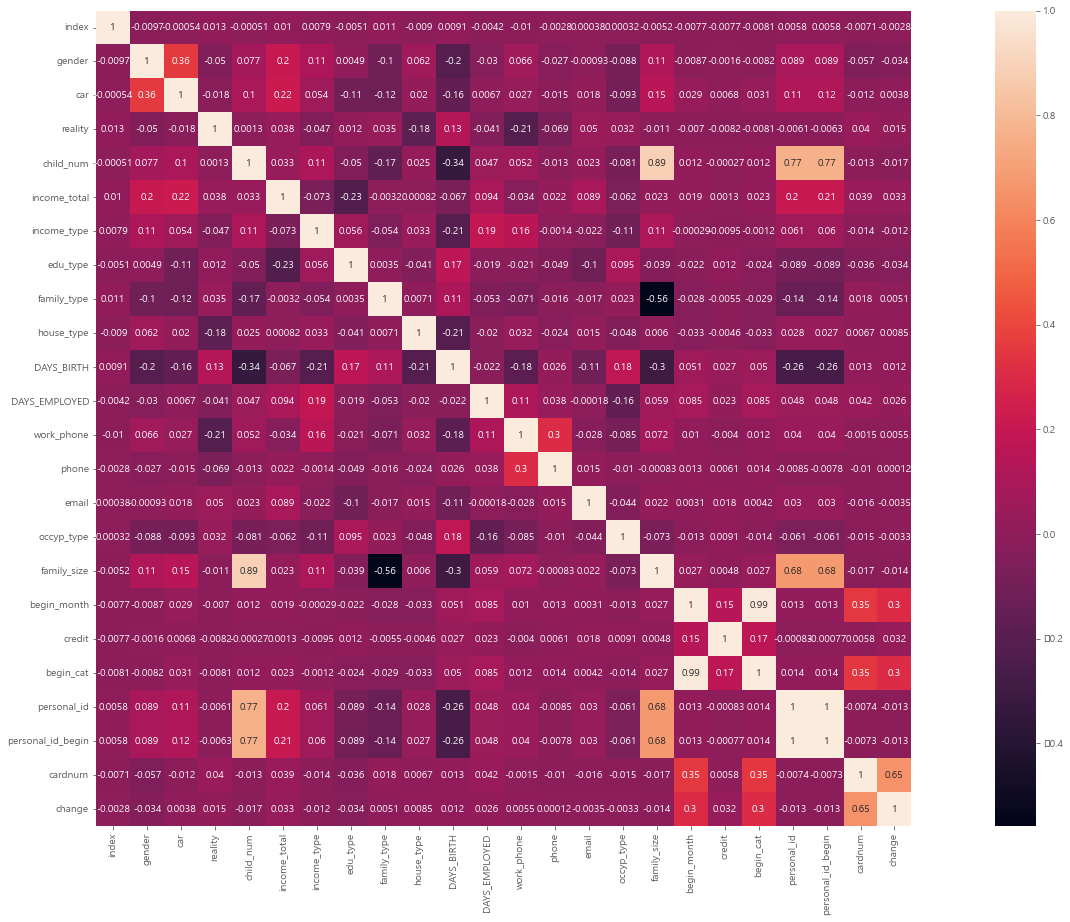

In [55]:
plt.figure(figsize = (30,15))
sns.heatmap(train.corr(),square = True, annot = True)
plt.show()

In [56]:
# 상관관계가 0.5 이상이면 색칠하는 함수
def draw_color_c(x,color):
    if (1>x>=0.5) or (-1<x<=-0.5):
        color = f'background-color:{color}'
        return color
    else:
        return ''
cor=train.corr()
cor.style.applymap(draw_color_c,color='#ff9090')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,begin_cat,personal_id,personal_id_begin,cardnum,change
index,1.000000,-0.009673,-0.000540,0.013435,-0.000510,0.010178,0.007950,-0.005118,0.011304,-0.008971,0.009071,-0.004178,-0.010356,-0.002818,0.000381,0.000317,-0.005249,-0.007674,-0.007717,-0.008060,0.005791,0.005786,-0.007091,-0.002788
gender,-0.009673,1.000000,0.359727,-0.050303,0.077186,0.202944,0.105740,0.004949,-0.103135,0.061806,-0.204836,-0.030417,0.066077,-0.027406,-0.000933,-0.087809,0.112261,-0.008748,-0.001560,-0.008159,0.088831,0.089226,-0.056870,-0.034445
car,-0.000540,0.359727,1.000000,-0.018449,0.103923,0.215294,0.053982,-0.107523,-0.122610,0.020411,-0.161670,0.006733,0.026928,-0.014802,0.017721,-0.092683,0.150834,0.028760,0.006844,0.031035,0.114320,0.115226,-0.011593,0.003831
reality,0.013435,-0.050303,-0.018449,1.000000,0.001271,0.037509,-0.047245,0.011731,0.035358,-0.179697,0.132321,-0.040784,-0.214361,-0.068867,0.050397,0.032342,-0.010761,-0.007038,-0.008221,-0.008108,-0.006097,-0.006314,0.039773,0.014783
child_num,-0.000510,0.077186,0.103923,0.001271,1.000000,0.033037,0.107775,-0.049809,-0.167580,0.024788,-0.338228,0.047237,0.052175,-0.012789,0.022517,-0.080785,0.886242,0.011961,-0.000273,0.011938,0.765515,0.765909,-0.013476,-0.017150
income_total,0.010178,0.202944,0.215294,0.037509,0.033037,1.000000,-0.072603,-0.225970,-0.003152,0.000822,-0.066748,0.093603,-0.033831,0.021653,0.089028,-0.061591,0.022522,0.019392,0.001275,0.022827,0.204964,0.208190,0.039381,0.032559
income_type,0.007950,0.105740,0.053982,-0.047245,0.107775,-0.072603,1.000000,0.056359,-0.053975,0.032836,-0.209147,0.190303,0.157570,-0.001369,-0.021933,-0.111989,0.108843,-0.000288,-0.009503,-0.001192,0.060552,0.060258,-0.013557,-0.011896
edu_type,-0.005118,0.004949,-0.107523,0.011731,-0.049809,-0.225970,0.056359,1.000000,0.003482,-0.040575,0.166119,-0.018884,-0.020969,-0.049427,-0.102528,0.094958,-0.039039,-0.021631,0.011829,-0.024405,-0.088656,-0.089431,-0.036201,-0.034268
family_type,0.011304,-0.103135,-0.122610,0.035358,-0.167580,-0.003152,-0.053975,0.003482,1.000000,0.007132,0.109313,-0.052759,-0.071405,-0.016148,-0.017415,0.023275,-0.557628,-0.028451,-0.005496,-0.029451,-0.136851,-0.137090,0.018021,0.005089
house_type,-0.008971,0.061806,0.020411,-0.179697,0.024788,0.000822,0.032836,-0.040575,0.007132,1.000000,-0.207825,-0.019689,0.032019,-0.024332,0.015276,-0.047510,0.005975,-0.032712,-0.004644,-0.032907,0.027510,0.027416,0.006668,0.008522


<correlation 0.5 이상>

- child_num: family_size, personal_id, personal_id_begin 
- family_type: family_size
- family_size: child_num, family_type, personal_id, personal_id_begin  
- personal_id: child_num, family_size, personal_id_begin
- personal_id_begin: child_num,family_size, personal
- cardnum: change

# Train, valid

In [57]:
X_train = train_processed.drop(['credit','index'], axis=1)
y_train = train_processed[['credit']]
X_test = test_processed.drop(['index'], axis=1)

In [58]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state = 42)
                                                    
print("Train set: ")
print(train_x.shape)
print(train_y.shape)
print("===========")
print("Validation set: ")
print(val_x.shape)
print(val_y.shape)
print("===========")

Train set: 
(16932, 22)
(16932, 1)
Validation set: 
(4233, 22)
(4233, 1)


# Feature Selection

Feature importances:
[0.011 0.016 0.015 0.004 0.065 0.019 0.018 0.027 0.012 0.146 0.114 0.01
 0.016 0.01  0.059 0.01  0.189 0.026 0.071 0.103 0.053 0.005]
gender:0.011
car:0.016
reality:0.015
child_num:0.004
income_total:0.065
income_type:0.019
edu_type:0.018
family_type:0.027
house_type:0.012
DAYS_BIRTH:0.146
DAYS_EMPLOYED:0.114
work_phone:0.010
phone:0.016
email:0.010
occyp_type:0.059
family_size:0.010
begin_month:0.189
begin_cat:0.026
personal_id:0.071
personal_id_begin:0.103
cardnum:0.053
change:0.005


<AxesSubplot:>

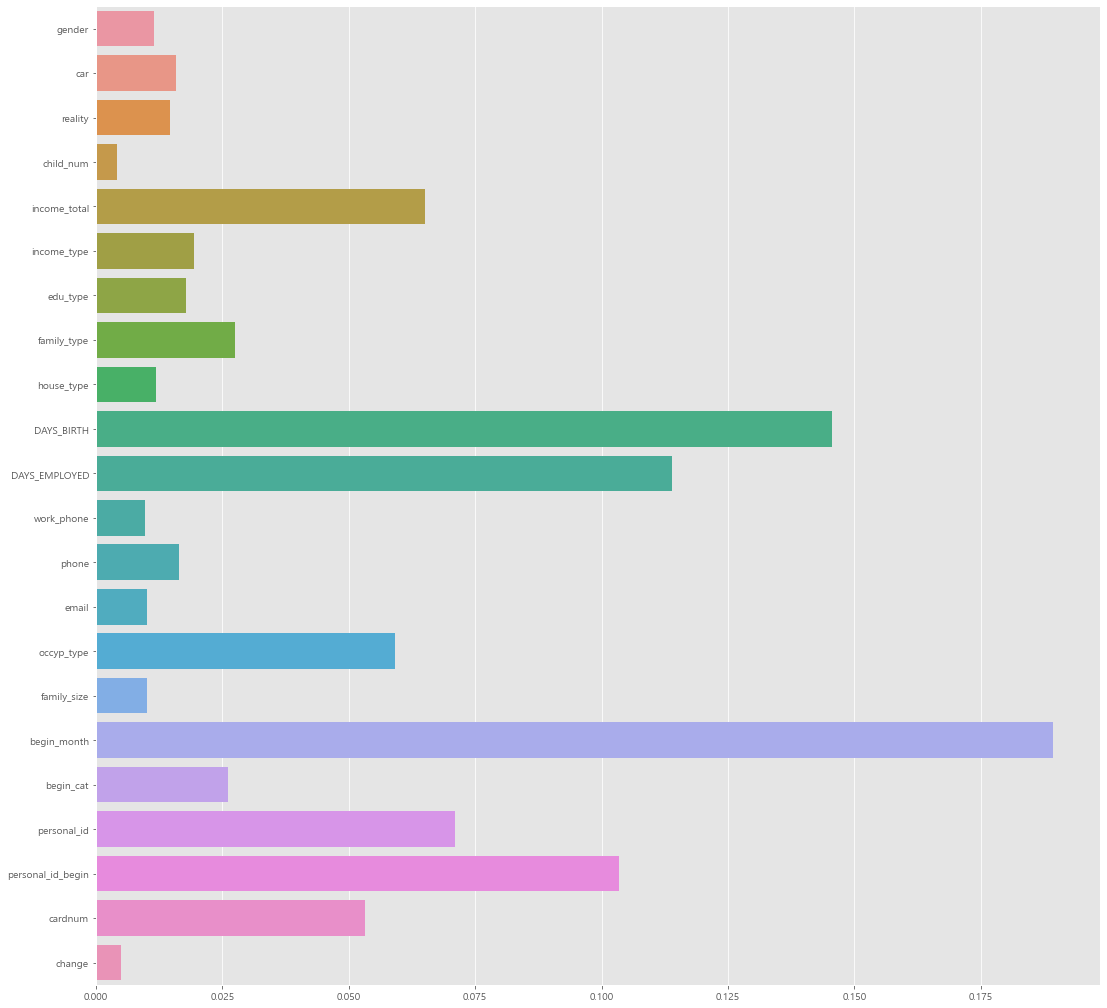

In [59]:
from sklearn.tree import DecisionTreeClassifier

dt_clf=DecisionTreeClassifier().fit(train_x,train_y)

import seaborn as sns
import numpy as np
%matplotlib inline

#feature imporetance 추출
print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_,3)))

#feature별 importance 매핑
for name, value in zip(train_x.columns, dt_clf.feature_importances_):
    print('{0}:{1:.3f}'.format(name,value))
    
#feature importance를 column 별로 시각화하기
f, ax = plt.subplots(1, 1, figsize=(18,18))
sns.barplot(x=dt_clf.feature_importances_, y=train_x.columns)

# Modeling(XGBoost)

XGBoost를 사용한 이유?
- 빠르고, 효율적.
- multiclass 분류 모델에 잘 적용됨.
- 데이터에 맞게 하이퍼파라미터를 다양하게 튜닝해서 사용할 수 있다.

In [60]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings 
import xgboost as xgb
X_train = train_processed.drop(['credit', 'index'], axis=1)
y_train = train_processed[['credit']]
X_test = test_processed.drop(['index'], axis=1)
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)


# 학습용
train_x = train_x[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'income_total', 'child_num', 'income_type', 'house_type', 'occyp_type', 'work_phone']]
val_x = val_x[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'income_total', 'child_num', 'income_type', 'house_type', 'occyp_type', 'work_phone']]

# 제출용
x_train = X_train[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'income_total', 'child_num', 'income_type', 'house_type', 'occyp_type', 'work_phone']]
x_test = X_test[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'income_total', 'child_num', 'income_type', 'house_type', 'occyp_type', 'work_phone']]

# parameter
args = {'eta':0.2, 'n_estimators':152,
        'max_depth':10, 'colsample_bytree':0.55, 'num_parallel_tree':3}
# 모델 선언
model = xgb.XGBClassifier(**args)

# 모델 훈련
model.fit(x_train,y_train) 

# 모델 예측
y_pred = model.predict(x_test)

In [ ]:
submission['credit'] = y_pred
submission.to_csv('submission_2조_6월2일.csv')

# 데이터셋과 관련하여 아쉬운 점

<AxesSubplot:xlabel='credit', ylabel='count'>

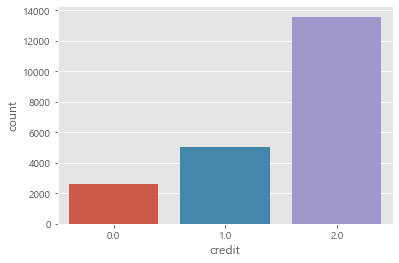

In [61]:
sns.countplot(train['credit'])

- 라벨간 데이터의 불균형이 극심했다. 오버샘플링, 언더샘플링을 적용해도 overfitting만 발생.
- feature들의 영향력이 적어서 고를 수 있는 선택지가 많지 않았다.
- 유일하게 영향력이 높은 변수인 begin_month에 대해서만 민감하게 반응함.